In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports for autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For geometric deep learning (if needed)
from torch_geometric.data import Data

In [2]:
print(f'Importing Data_preprocess_3Omics processed datasets for direct fusion analysis')
print("=" * 80)

# Load the preprocessed datasets from Data_preprocess_3Omics pipeline
print("🔄 Loading preprocessed datasets...")
expression_scaled2 = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0)
methylation_scaled2 = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0)
copy_number_scaled2 = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0)
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

print("📊 Original Dataset Shapes (Features x Samples):")
print(f"   Expression: {expression_scaled2.shape} (genes x samples)")
print(f"   Methylation: {methylation_scaled2.shape} (CpG sites x samples)")
print(f"   Copy Number: {copy_number_scaled2.shape} (regions x samples)")
print(f"   Phenotype: {phenotype_data_clean2.shape} (samples x features)")
print(f"   Labels: {labels.shape} (samples)")

# Transpose omics data to have samples as rows (required for ML models)
print("\n🔄 Transposing omics data (samples as rows)...")
expression_scaled2 = expression_scaled2.T  # Now (samples x genes)
methylation_scaled2 = methylation_scaled2.T  # Now (samples x CpG sites)
copy_number_scaled2 = copy_number_scaled2.T  # Now (samples x regions)

expression_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns
)

methylation_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns
)

copy_number_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns
)

print("\n✅ Omics data standardized (samples as rows, features scaled column-wise).")
# print("Expression data (final scaled shape):", expression_scaled_final.shape)

print("📊 After transpose (Samples x Features):")
print(f"   Expression: {expression_scaled2.shape} (samples x genes)")
print(f"   Methylation: {methylation_scaled2.shape} (samples x CpG sites)")
print(f"   Copy Number: {copy_number_scaled2.shape} (samples x regions)")

# Verify data quality (should have no missing values from preprocessing)
print("\n🔍 Data Quality Check:")
print(f"   Expression missing values: {expression_scaled2.isnull().sum().sum()}")
print(f"   Methylation missing values: {methylation_scaled2.isnull().sum().sum()}")
print(f"   Copy Number missing values: {copy_number_scaled2.isnull().sum().sum()}")
print(f"   Labels missing values: {labels.isnull().sum().sum()}")

# Check sample alignment (should be perfect from preprocessing)
common_samples_check = [
    set(expression_scaled2.index),
    set(methylation_scaled2.index), 
    set(copy_number_scaled2.index),
    set(labels.index)
]

all_aligned = all(s == common_samples_check[0] for s in common_samples_check)
print(f"\n✅ Sample alignment: {'Perfect' if all_aligned else 'Misaligned'}")
print(f"📊 Total samples: {len(expression_scaled2)}")


Importing Data_preprocess_3Omics processed datasets for direct fusion analysis
🔄 Loading preprocessed datasets...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...

✅ Omics data standardized (samples as rows, features scaled column-wise).
📊 After transpose (Samples x Features):
   Expression: (205, 44663) (samples x genes)
   Methylation: (205, 419542) (samples x CpG sites)
   Copy Number: (205, 56756) (samples x

In [3]:
# Concatenate All Omics Data First, Then Apply PCA
print("Concatenating All Omics Data First, Then Applying PCA...")
print("=" * 80)

# First concatenate all omics data
print(f"\n🔗 Creating Direct Fusion from Raw Omics Data...")
raw_omics_fusion = pd.concat([
    expression_scaled2,
    methylation_scaled2, 
    copy_number_scaled2
], axis=1)

print(f"📊 Raw fusion data shape: {raw_omics_fusion.shape}")
print(f"   Expression features: {expression_scaled2.shape[1]}")
print(f"   Methylation features: {methylation_scaled2.shape[1]}")
print(f"   Copy Number features: {copy_number_scaled2.shape[1]}")
print(f"   Total features: {raw_omics_fusion.shape[1]}")

# Apply PCA to the concatenated data
pca_components = 70  # Single PCA with 70 components
print(f"\n🔄 Applying PCA with {pca_components} components to concatenated data...")

pca_fusion = PCA(n_components=pca_components, random_state=42)
fpca_individual_fusion = pd.DataFrame(
    pca_fusion.fit_transform(raw_omics_fusion),
    index=raw_omics_fusion.index,
    columns=[f'PC{i+1}' for i in range(pca_components)]
)

print(f"✅ PCA transformation completed!")
print(f"📊 Final PCA fusion shape: {fpca_individual_fusion.shape}")

# Print explained variance information
explained_variance_ratio = pca_fusion.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\n📈 PCA Explained Variance Analysis:")
print(f"   First 10 components explain: {cumulative_variance[9]:.3%} of variance")
print(f"   First 20 components explain: {cumulative_variance[19]:.3%} of variance")
print(f"   First 30 components explain: {cumulative_variance[29]:.3%} of variance")
print(f"   All {pca_components} components explain: {cumulative_variance[-1]:.3%} of variance")

# Verify no missing values
print(f"\n🔍 Data Quality Check:")
print(f"   PCA fusion missing values: {fpca_individual_fusion.isnull().sum().sum()}")

Concatenating All Omics Data First, Then Applying PCA...

🔗 Creating Direct Fusion from Raw Omics Data...
📊 Raw fusion data shape: (205, 520961)
   Expression features: 44663
   Methylation features: 419542
   Copy Number features: 56756
   Total features: 520961

🔄 Applying PCA with 70 components to concatenated data...
📊 Raw fusion data shape: (205, 520961)
   Expression features: 44663
   Methylation features: 419542
   Copy Number features: 56756
   Total features: 520961

🔄 Applying PCA with 70 components to concatenated data...
✅ PCA transformation completed!
📊 Final PCA fusion shape: (205, 70)

📈 PCA Explained Variance Analysis:
   First 10 components explain: 37.169% of variance
   First 20 components explain: 46.756% of variance
   First 30 components explain: 53.111% of variance
   All 70 components explain: 69.956% of variance

🔍 Data Quality Check:
   PCA fusion missing values: 0
✅ PCA transformation completed!
📊 Final PCA fusion shape: (205, 70)

📈 PCA Explained Variance A

PCA VARIANCE DISTRIBUTION ANALYSIS


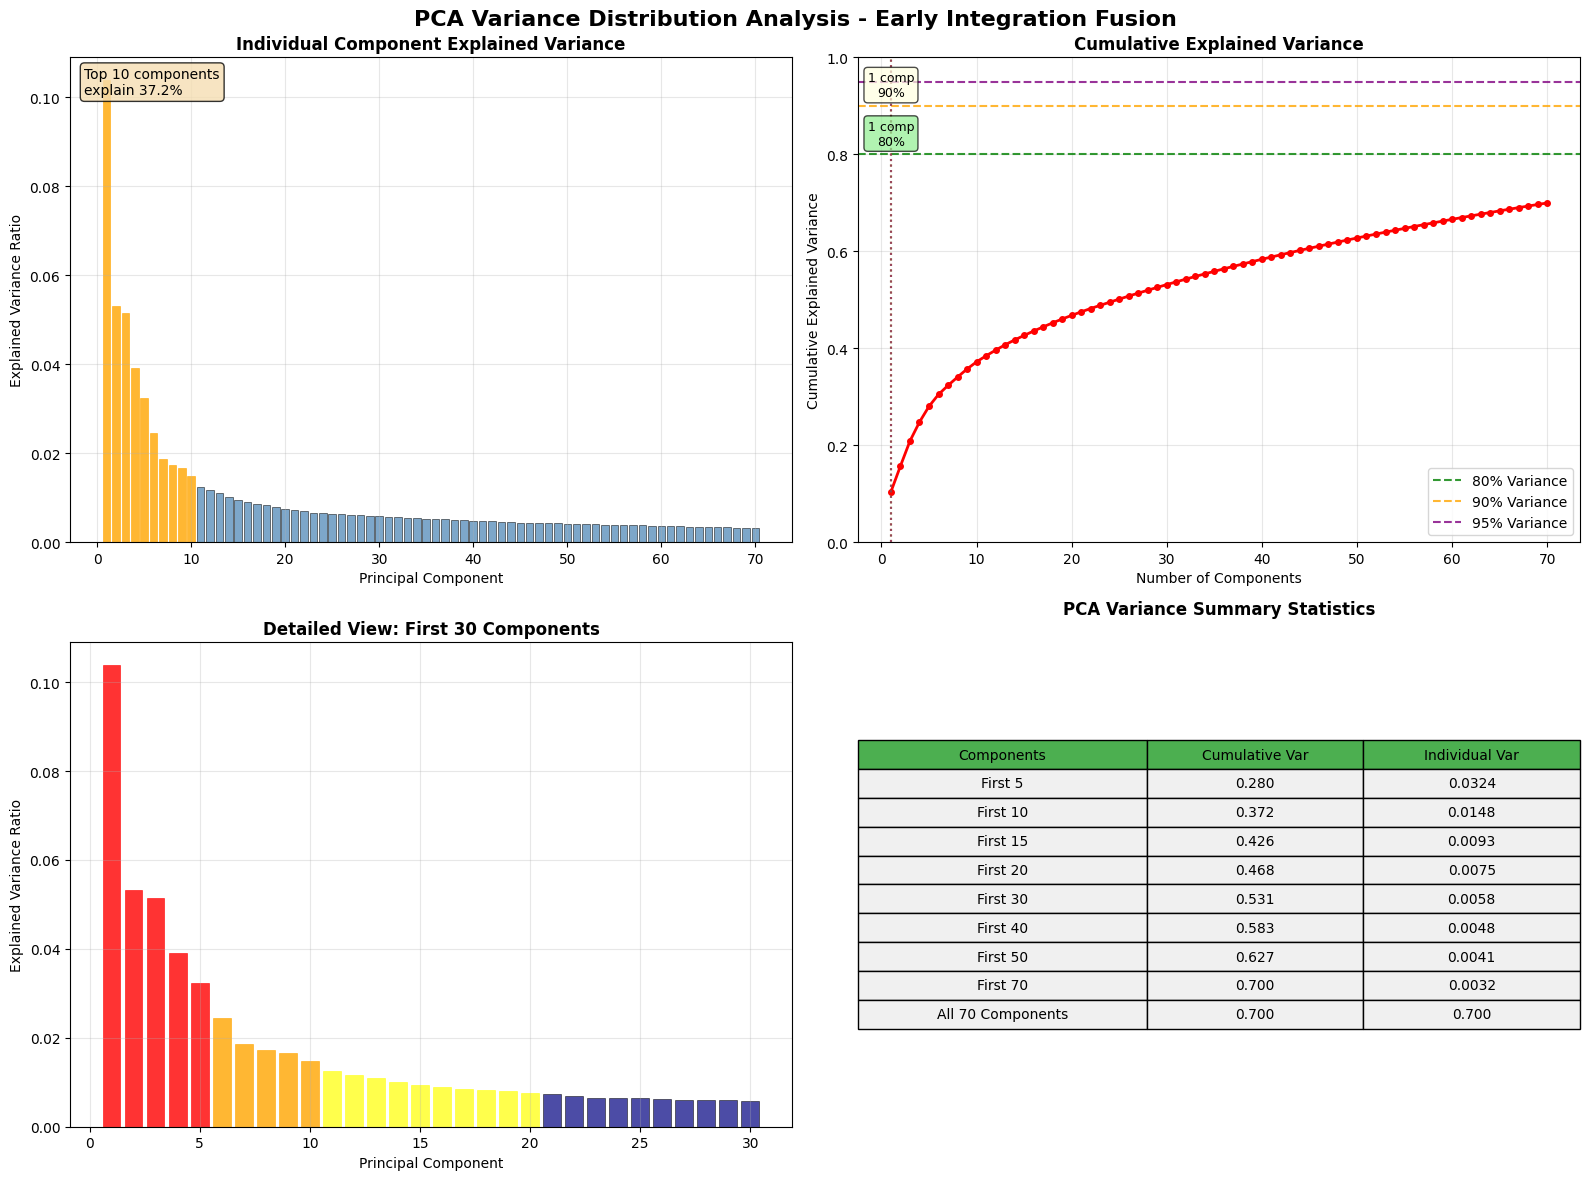


📊 DETAILED PCA VARIANCE ANALYSIS

🔍 Key Insights:
   • Most informative component (PC1): 10.382%
   • Least informative component (PC70): 0.3175%
   • Components needed for 80% variance: 1
   • Components needed for 90% variance: 1
   • Components needed for 95% variance: 1

📈 Variance Distribution:
   • Top 5 components: 27.99%
   • Top 10 components: 37.17%
   • Top 20 components: 46.76%
   • All 70 components: 69.96%

🎯 Component Effectiveness:
   • High variance (>1%): 14 components
   • Medium variance (0.5-1%): 23 components
   • Low variance (≤0.5%): 33 components

✅ PCA variance analysis completed!
📊 Total variance captured by 70 components: 69.96%


In [4]:
# PCA Variance Distribution Visualization
print("PCA VARIANCE DISTRIBUTION ANALYSIS")
print("=" * 80)

# Create comprehensive PCA variance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('PCA Variance Distribution Analysis - Early Integration Fusion', fontsize=16, fontweight='bold')

# 1. Individual Component Variance (Bar Plot)
ax1 = axes[0, 0]
components = range(1, len(explained_variance_ratio) + 1)
bars = ax1.bar(components, explained_variance_ratio, 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_title('Individual Component Explained Variance', fontweight='bold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.grid(True, alpha=0.3)

# Highlight top 10 components
for i, bar in enumerate(bars[:10]):
    bar.set_color('orange')
    bar.set_alpha(0.8)

# Add text annotation for top components
ax1.text(0.02, 0.98, f'Top 10 components\nexplain {cumulative_variance[9]:.1%}', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

# 2. Cumulative Variance (Line Plot)
ax2 = axes[0, 1]
ax2.plot(components, cumulative_variance, 'o-', color='red', linewidth=2, markersize=4)
ax2.axhline(y=0.80, color='green', linestyle='--', alpha=0.8, label='80% Variance')
ax2.axhline(y=0.90, color='orange', linestyle='--', alpha=0.8, label='90% Variance')
ax2.axhline(y=0.95, color='purple', linestyle='--', alpha=0.8, label='95% Variance')

# Find components needed for different variance thresholds
comp_80 = np.argmax(cumulative_variance >= 0.80) + 1
comp_90 = np.argmax(cumulative_variance >= 0.90) + 1
comp_95 = np.argmax(cumulative_variance >= 0.95) + 1

ax2.axvline(x=comp_80, color='green', linestyle=':', alpha=0.6)
ax2.axvline(x=comp_90, color='orange', linestyle=':', alpha=0.6)
ax2.axvline(x=comp_95, color='purple', linestyle=':', alpha=0.6)

ax2.set_title('Cumulative Explained Variance', fontweight='bold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# Add annotations for key thresholds
ax2.text(comp_80, 0.82, f'{comp_80} comp\n80%', ha='center', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax2.text(comp_90, 0.92, f'{comp_90} comp\n90%', ha='center', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# 3. Variance Distribution (First 30 components detailed)
ax3 = axes[1, 0]
first_30_components = range(1, min(31, len(explained_variance_ratio) + 1))
first_30_variance = explained_variance_ratio[:30]

bars3 = ax3.bar(first_30_components, first_30_variance, 
                color='navy', alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.set_title('Detailed View: First 30 Components', fontweight='bold')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained Variance Ratio')
ax3.grid(True, alpha=0.3)

# Color-code by importance
for i, bar in enumerate(bars3):
    if i < 5:  # Top 5
        bar.set_color('red')
        bar.set_alpha(0.8)
    elif i < 10:  # Top 6-10
        bar.set_color('orange')
        bar.set_alpha(0.8)
    elif i < 20:  # Top 11-20
        bar.set_color('yellow')
        bar.set_alpha(0.7)

# 4. Variance Summary Table
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary statistics
summary_data = []
milestones = [5, 10, 15, 20, 30, 40, 50, 70]
for milestone in milestones:
    if milestone <= len(cumulative_variance):
        summary_data.append([
            f'First {milestone}',
            f'{cumulative_variance[milestone-1]:.3f}',
            f'{explained_variance_ratio[milestone-1]:.4f}' if milestone <= len(explained_variance_ratio) else 'N/A'
        ])

# Add total variance explained
summary_data.append(['All 70 Components', f'{cumulative_variance[-1]:.3f}', f'{explained_variance_ratio.sum():.3f}'])

table = ax4.table(cellText=summary_data,
                  colLabels=['Components', 'Cumulative Var', 'Individual Var'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Style the table
table[(0, 0)].set_facecolor('#4CAF50')
table[(0, 1)].set_facecolor('#4CAF50')
table[(0, 2)].set_facecolor('#4CAF50')
for i in range(len(summary_data)):
    table[(i+1, 0)].set_facecolor('#f0f0f0')
    table[(i+1, 1)].set_facecolor('#f0f0f0')
    table[(i+1, 2)].set_facecolor('#f0f0f0')

ax4.set_title('PCA Variance Summary Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed variance analysis
print(f"\n📊 DETAILED PCA VARIANCE ANALYSIS")
print("=" * 60)

print(f"\n🔍 Key Insights:")
print(f"   • Most informative component (PC1): {explained_variance_ratio[0]:.3%}")
print(f"   • Least informative component (PC70): {explained_variance_ratio[-1]:.4%}")
print(f"   • Components needed for 80% variance: {comp_80}")
print(f"   • Components needed for 90% variance: {comp_90}")
print(f"   • Components needed for 95% variance: {comp_95}")

print(f"\n📈 Variance Distribution:")
print(f"   • Top 5 components: {cumulative_variance[4]:.2%}")
print(f"   • Top 10 components: {cumulative_variance[9]:.2%}")
print(f"   • Top 20 components: {cumulative_variance[19]:.2%}")
print(f"   • All 70 components: {cumulative_variance[-1]:.2%}")

print(f"\n🎯 Component Effectiveness:")
high_variance_components = np.sum(explained_variance_ratio > 0.01)
medium_variance_components = np.sum((explained_variance_ratio > 0.005) & (explained_variance_ratio <= 0.01))
low_variance_components = np.sum(explained_variance_ratio <= 0.005)

print(f"   • High variance (>1%): {high_variance_components} components")
print(f"   • Medium variance (0.5-1%): {medium_variance_components} components")
print(f"   • Low variance (≤0.5%): {low_variance_components} components")

print(f"\n✅ PCA variance analysis completed!")
print(f"📊 Total variance captured by 70 components: {cumulative_variance[-1]:.2%}")

In [5]:
# Machine Learning Model Training and Evaluation
print("MACHINE LEARNING MODEL TRAINING AND EVALUATION")
print("=" * 80)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Prepare data for ML
X_scaled = StandardScaler().fit_transform(fpca_individual_fusion)
y = labels.values.ravel()

print(f"📊 Training data shape: {X_scaled.shape}")
print(f"📊 Labels shape: {y.shape}")
print(f"📊 Number of classes: {len(np.unique(y))}")

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'SVM_RBF': SVC(kernel='rbf', random_state=42, probability=True),
    'SVM_Linear': SVC(kernel='linear', random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42)
}

print(f"\n🔄 Training {len(models)} machine learning models...")

# Train and evaluate models
ml_results = {}
results_data = []

for model_name, model in models.items():
    print(f"\n   Training {model_name}...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Store results
    ml_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    results_data.append({
        'Model': model_name,
        'Test_Accuracy': accuracy,
        'F1_Macro': f1
    })
    
    print(f"      Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Test_Accuracy', ascending=False)

print(f"\n📊 MODEL PERFORMANCE RANKING")
print("="*50)
print(results_df.to_string(index=False, float_format='%.4f'))

# Best model identification
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Test_Accuracy']
best_f1 = results_df.iloc[0]['F1_Macro']

print(f"\n🏆 BEST PERFORMING MODEL")
print("="*50)
print(f"   Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f}")
print(f"   F1-Macro Score: {best_f1:.4f}")

# # Feature importance analysis for tree-based models
# print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
# print("="*50)

# tree_models = ['RandomForest', 'GradientBoosting', 'DecisionTree']
# available_tree_models = [model for model in tree_models if model in ml_results]

# if available_tree_models:
#     print(f"📊 Analyzing feature importance for tree-based models...")
    
#     # Get feature importance from the best tree-based model
#     best_tree_model = None
#     best_tree_accuracy = 0
    
#     for model_name in available_tree_models:
#         if ml_results[model_name]['accuracy'] > best_tree_accuracy:
#             best_tree_accuracy = ml_results[model_name]['accuracy']
#             best_tree_model = model_name
    
#     if best_tree_model:
#         importances = ml_results[best_tree_model]['model'].feature_importances_
#         feature_names = [f'PC{i+1}' for i in range(len(importances))]
        
#         # Sort by importance
#         importance_indices = np.argsort(importances)[::-1]
        
#         print(f"\n   Top 10 Most Important Features ({best_tree_model}):")
#         print("   " + "-" * 40)
#         for rank, idx in enumerate(importance_indices[:10], 1):
#             print(f"   {rank:2d}. {feature_names[idx]:8s}: {importances[idx]:.4f}")
        
#         print(f"\n   Bottom 5 Least Important Features ({best_tree_model}):")
#         print("   " + "-" * 40)
#         for rank, idx in enumerate(importance_indices[-5:], 1):
#             print(f"   {rank:2d}. {feature_names[idx]:8s}: {importances[idx]:.4f}")

# else:
#     print("No tree-based models available for feature importance analysis.")

# # Model Performance Summary
# print(f"\n{'='*80}")
# print("📊 MODEL PERFORMANCE SUMMARY")
# print("="*80)

# print(f"\n🏆 Overall Rankings (by Test Accuracy):")
# print("-" * 50)
# for rank, (_, row) in enumerate(results_df.iterrows(), 1):
#     model_name = row['Model']
#     accuracy = row['Test_Accuracy']
#     f1 = row['F1_Macro']
#     print(f"   {rank}. {model_name:18s}: Acc={accuracy:.4f}, F1={f1:.4f}")

# print(f"\n✅ Machine learning evaluation completed!")
# print(f"🎯 Best model ({best_model_name}) achieves {best_accuracy:.1%} accuracy")

MACHINE LEARNING MODEL TRAINING AND EVALUATION
📊 Training data shape: (205, 70)
📊 Labels shape: (205,)
📊 Number of classes: 4

🔄 Training 8 machine learning models...

   Training RandomForest...
      Accuracy: 0.6341, F1-Score: 0.4207

   Training GradientBoosting...
      Accuracy: 0.6341, F1-Score: 0.4207

   Training GradientBoosting...
      Accuracy: 0.6098, F1-Score: 0.4923

   Training LogisticRegression...
      Accuracy: 0.7317, F1-Score: 0.6111

   Training SVM_RBF...
      Accuracy: 0.6585, F1-Score: 0.4461

   Training SVM_Linear...
      Accuracy: 0.6098, F1-Score: 0.4470

   Training KNN...
      Accuracy: 0.6098, F1-Score: 0.4923

   Training LogisticRegression...
      Accuracy: 0.7317, F1-Score: 0.6111

   Training SVM_RBF...
      Accuracy: 0.6585, F1-Score: 0.4461

   Training SVM_Linear...
      Accuracy: 0.6098, F1-Score: 0.4470

   Training KNN...
      Accuracy: 0.5366, F1-Score: 0.4010

   Training NaiveBayes...
      Accuracy: 0.5610, F1-Score: 0.3970

   Tra

# Direct ML Classification on PCA Fusion

This section implements direct machine learning classification on the PCA-fused multi-omics data without autoencoders.

In [6]:
# Direct ML Classification on PCA Fusion Data
print("DIRECT ML CLASSIFICATION ON PCA FUSION")
print("=" * 80)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                           roc_auc_score, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Initialize ML models
ml_models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'SVM_RBF': SVC(kernel='rbf', random_state=42, probability=True),
    'NaiveBayes': GaussianNB()
}

print(f"✅ ML Models initialized: {list(ml_models.keys())}")
print(f"📊 Fusion data shape: {fpca_individual_fusion.shape}")
print(f"📊 Labels shape: {labels.shape}")

# Prepare data
X = fpca_individual_fusion.values
y = labels.values.ravel()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Data prepared and standardized")
print(f"   Features shape: {X_scaled.shape}")
print(f"   Labels shape: {y.shape}")
print(f"   Unique classes: {np.unique(y)}")
print(f"   Class distribution: {', '.join([f'Class {i}: {count}' for i, count in enumerate(np.bincount(y.astype(int)))])}")

DIRECT ML CLASSIFICATION ON PCA FUSION
✅ ML Models initialized: ['RandomForest', 'GradientBoosting', 'LogisticRegression', 'SVM_RBF', 'NaiveBayes']
📊 Fusion data shape: (205, 70)
📊 Labels shape: (205, 1)
✅ Data prepared and standardized
   Features shape: (205, 70)
   Labels shape: (205,)
   Unique classes: [0 1 2 3]
   Class distribution: Class 0: 53, Class 1: 22, Class 2: 96, Class 3: 34


In [7]:
# ML Models Evaluation Function
print("EVALUATING ML MODELS ON PCA FUSION DATA")
print("=" * 80)

def evaluate_ml_models_comprehensive(X, y, models, k_folds=5, test_size=0.2):
    """
    Comprehensive evaluation of ML models with train/test split and cross-validation
    
    Args:
        X: Feature matrix
        y: Target labels
        models: Dictionary of ML models
        k_folds: Number of cross-validation folds
        test_size: Proportion of data for testing
        
    Returns:
        Dictionary with comprehensive metrics for each model
    """
    results = {}
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"📊 Data split:")
    print(f"   Train set: {X_train.shape[0]} samples")
    print(f"   Test set: {X_test.shape[0]} samples")
    print(f"   Train class distribution: {', '.join([f'Class {i}: {count}' for i, count in enumerate(np.bincount(y_train.astype(int)))])}")
    print(f"   Test class distribution: {', '.join([f'Class {i}: {count}' for i, count in enumerate(np.bincount(y_test.astype(int)))])}")
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        print(f"\n⚙️  Evaluating {model_name}...")
        
        # Cross-validation on full dataset
        cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
        cv_f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')
        
        # Train on train set and evaluate on test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate comprehensive metrics on test set
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
        precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
        recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
        recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
        
        # AUC (one-vs-rest for multiclass)
        try:
            n_classes = len(np.unique(y_test))
            if n_classes == 2:
                auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
        except Exception as e:
            print(f"     Warning: Could not calculate AUC for {model_name}: {e}")
            auc = None
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision_macro': precision_macro,
            'precision_micro': precision_micro,
            'recall_macro': recall_macro,
            'recall_micro': recall_micro,
            'auc': auc,
            'cv_accuracy_mean': cv_scores.mean(),
            'cv_accuracy_std': cv_scores.std(),
            'cv_f1_mean': cv_f1_scores.mean(),
            'cv_f1_std': cv_f1_scores.std(),
            'confusion_matrix': cm,
            'model': model  # Store trained model
        }
        
        print(f"   ✅ {model_name}")
        print(f"      Test Accuracy: {accuracy:.4f}")
        print(f"      Test F1-Macro: {f1_macro:.4f}")
        print(f"      CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        if auc is not None:
            print(f"      Test AUC: {auc:.4f}")
    
    return results, X_train, X_test, y_train, y_test

# Evaluate all models
ml_results, X_train, X_test, y_train, y_test = evaluate_ml_models_comprehensive(
    X_scaled, y, ml_models, k_folds=5, test_size=0.2
)

print(f"\n{'='*80}")
print(f"✅ ML MODEL EVALUATION COMPLETED!")
print(f"{'='*80}")
print(f"Models evaluated: {list(ml_results.keys())}")

EVALUATING ML MODELS ON PCA FUSION DATA
📊 Data split:
   Train set: 164 samples
   Test set: 41 samples
   Train class distribution: Class 0: 42, Class 1: 18, Class 2: 77, Class 3: 27
   Test class distribution: Class 0: 11, Class 1: 4, Class 2: 19, Class 3: 7

⚙️  Evaluating RandomForest...
   ✅ RandomForest
      Test Accuracy: 0.6341
      Test F1-Macro: 0.4207
      CV Accuracy: 0.6732 (±0.0249)
      Test AUC: 0.8363

⚙️  Evaluating GradientBoosting...
   ✅ RandomForest
      Test Accuracy: 0.6341
      Test F1-Macro: 0.4207
      CV Accuracy: 0.6732 (±0.0249)
      Test AUC: 0.8363

⚙️  Evaluating GradientBoosting...
   ✅ GradientBoosting
      Test Accuracy: 0.6098
      Test F1-Macro: 0.4923
      CV Accuracy: 0.5707 (±0.0548)
      Test AUC: 0.7628

⚙️  Evaluating LogisticRegression...
   ✅ LogisticRegression
      Test Accuracy: 0.7317
      Test F1-Macro: 0.6111
      CV Accuracy: 0.7122 (±0.0239)
      Test AUC: 0.8018

⚙️  Evaluating SVM_RBF...
   ✅ GradientBoosting
      

RESULTS VISUALIZATION AND ANALYSIS
🔄 Calculating C-Index and preparing enhanced results...
   ✅ RandomForest: C-Index = 0.5220
   ✅ GradientBoosting: C-Index = 0.4921
   ✅ LogisticRegression: C-Index = 0.6173
   ✅ SVM_RBF: C-Index = 0.5908
   ✅ NaiveBayes: C-Index = 0.5591

📊 COMPREHENSIVE ML RESULTS TABLE (Including C-Index)
             Model  Test_Accuracy  Test_F1_Macro  Test_F1_Micro  Test_Precision_Macro  Test_Precision_Micro  Test_Recall_Macro  Test_Recall_Micro  Test_AUC  Test_C_Index  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std
LogisticRegression         0.7317         0.6111         0.7317                0.6168                0.7317             0.6074             0.7317    0.8018        0.6173            0.7122           0.0239      0.5899     0.0433
           SVM_RBF         0.6585         0.4461         0.6585                0.5202                0.6585             0.4544             0.6585    0.8869        0.5908            0.6683           0.0331      0.4348

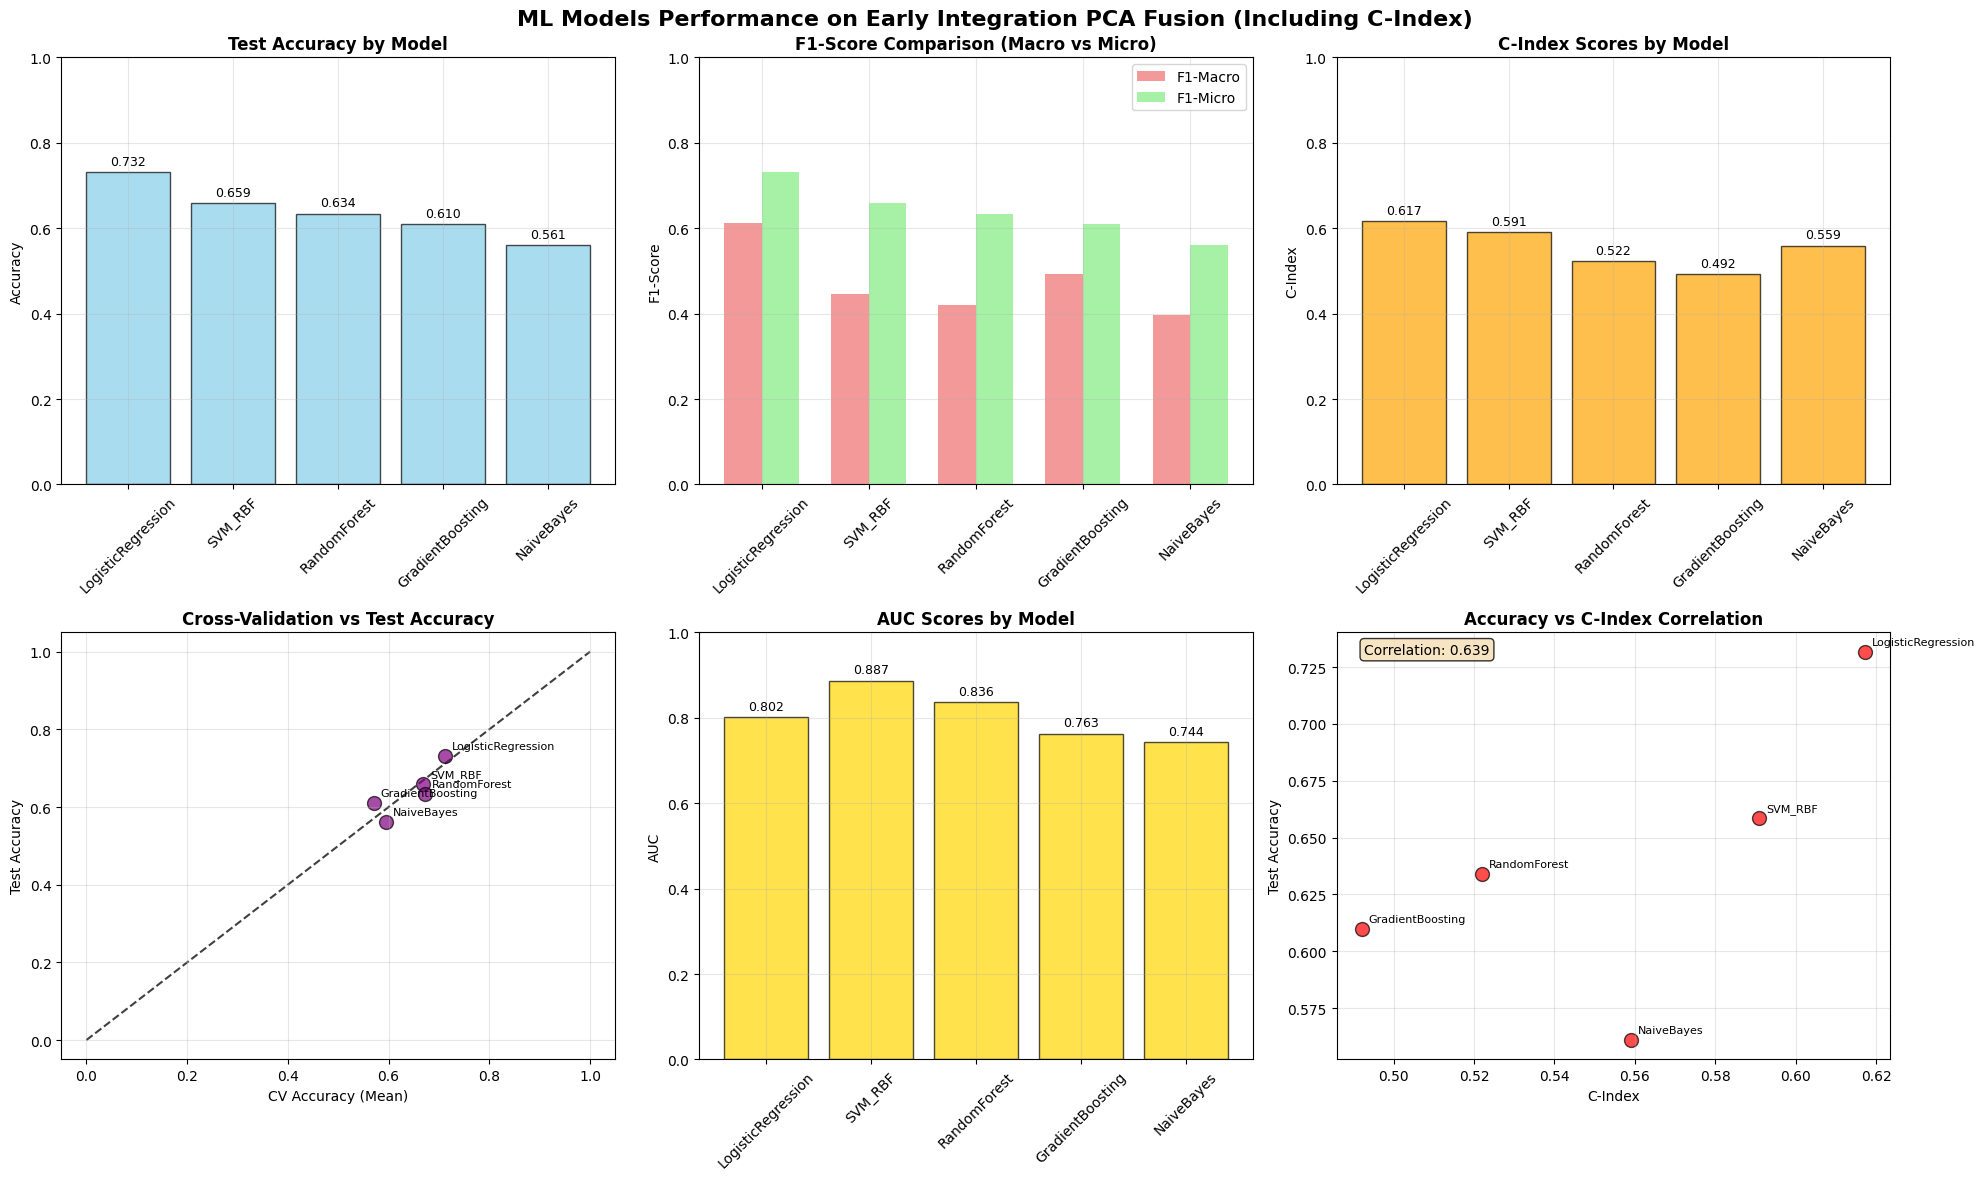


✅ Enhanced visualization completed!
📊 Results with C-Index saved in 'ml_results' dictionary and 'results_df' DataFrame
🎯 C-Index measures concordance between model predictions and true class rankings


In [8]:
# Results Visualization and Analysis
print("RESULTS VISUALIZATION AND ANALYSIS")
print("=" * 80)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
import numpy as np

# Calculate C-index (Concordance Index) for each model
def calculate_cindex(y_true, y_pred_proba):
    """
    Calculate C-index (Concordance Index) for multi-class classification.
    This measures the probability that a randomly chosen pair of observations
    are correctly ordered by the model.
    """
    if y_pred_proba is None:
        return np.nan
    
    n_samples = len(y_true)
    if n_samples < 2:
        return np.nan
    
    concordant_pairs = 0
    total_pairs = 0
    
    # For multi-class, we use the probability of the true class
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if y_true[i] != y_true[j]:  # Only consider pairs with different true classes
                # Get probability of true class for each sample
                prob_i = y_pred_proba[i, int(y_true[i])]
                prob_j = y_pred_proba[j, int(y_true[j])]
                
                # Check if the model correctly orders the probabilities
                # Higher probability should go to the sample with the "better" outcome
                # For cancer subtypes, we assume lower class numbers indicate better prognosis
                if (y_true[i] < y_true[j] and prob_i > prob_j) or \
                   (y_true[i] > y_true[j] and prob_i < prob_j):
                    concordant_pairs += 1
                
                total_pairs += 1
    
    return concordant_pairs / total_pairs if total_pairs > 0 else np.nan

# Enhanced ML Results Collection with C-Index
enhanced_ml_results = {}
results_data = []

print("🔄 Calculating C-Index and preparing enhanced results...")

for model_name, model_info in ml_results.items():
    model = model_info['model']
    
    # Get fresh predictions on test set for C-Index calculation
    y_pred = model.predict(X_test)
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = None
    
    # Calculate C-index
    cindex = calculate_cindex(y_test, y_pred_proba)
    
    # Use existing metrics from ml_results and add C-index
    enhanced_ml_results[model_name] = {
        'model': model,
        'accuracy': model_info['accuracy'],
        'f1_macro': model_info['f1_macro'],
        'f1_micro': model_info['f1_micro'],
        'precision_macro': model_info['precision_macro'],
        'precision_micro': model_info['precision_micro'],
        'recall_macro': model_info['recall_macro'],
        'recall_micro': model_info['recall_micro'],
        'auc': model_info['auc'],
        'cindex': cindex,
        'cv_accuracy_mean': model_info['cv_accuracy_mean'],
        'cv_accuracy_std': model_info['cv_accuracy_std'],
        'cv_f1_mean': model_info['cv_f1_mean'],
        'cv_f1_std': model_info['cv_f1_std'],
        'confusion_matrix': model_info['confusion_matrix'],
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    results_data.append({
        'Model': model_name,
        'Test_Accuracy': model_info['accuracy'],
        'Test_F1_Macro': model_info['f1_macro'],
        'Test_F1_Micro': model_info['f1_micro'],
        'Test_Precision_Macro': model_info['precision_macro'],
        'Test_Precision_Micro': model_info['precision_micro'],
        'Test_Recall_Macro': model_info['recall_macro'],
        'Test_Recall_Micro': model_info['recall_micro'],
        'Test_AUC': model_info['auc'],
        'Test_C_Index': cindex,
        'CV_Accuracy_Mean': model_info['cv_accuracy_mean'],
        'CV_Accuracy_Std': model_info['cv_accuracy_std'],
        'CV_F1_Mean': model_info['cv_f1_mean'],
        'CV_F1_Std': model_info['cv_f1_std']
    })
    
    print(f"   ✅ {model_name}: C-Index = {cindex:.4f}" if not np.isnan(cindex) else f"   ⚠️  {model_name}: C-Index = N/A (no probabilities)")

# Update ml_results with enhanced version
ml_results = enhanced_ml_results

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Test_Accuracy', ascending=False)

print("\n📊 COMPREHENSIVE ML RESULTS TABLE (Including C-Index)")
print("=" * 120)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(results_df.to_string(index=False))

# Find best performing model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Test_Accuracy']
best_f1 = results_df.iloc[0]['Test_F1_Macro']
best_auc = results_df.iloc[0]['Test_AUC']
best_cindex = results_df.iloc[0]['Test_C_Index']

print(f"\n🏆 BEST PERFORMING MODEL")
print("=" * 50)
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Test F1-Macro: {best_f1:.4f}")
if not pd.isna(best_auc):
    print(f"Test AUC: {best_auc:.4f}")
if not pd.isna(best_cindex):
    print(f"Test C-Index: {best_cindex:.4f}")

# C-Index Analysis
print(f"\n📊 C-INDEX ANALYSIS")
print("=" * 50)
cindex_data = results_df.dropna(subset=['Test_C_Index'])
if len(cindex_data) > 0:
    print("C-Index Rankings (Higher is better):")
    cindex_sorted = cindex_data.sort_values('Test_C_Index', ascending=False)
    for rank, (_, row) in enumerate(cindex_sorted.iterrows(), 1):
        model_name = row['Model']
        cindex_val = row['Test_C_Index']
        accuracy_val = row['Test_Accuracy']
        print(f"   {rank}. {model_name:18s}: C-Index={cindex_val:.4f}, Accuracy={accuracy_val:.4f}")
    
    best_cindex_model = cindex_sorted.iloc[0]['Model']
    best_cindex_value = cindex_sorted.iloc[0]['Test_C_Index']
    print(f"\n🎯 Best C-Index: {best_cindex_model} ({best_cindex_value:.4f})")
else:
    print("No C-Index scores available (models without probability predictions)")

# Create enhanced visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('ML Models Performance on Early Integration PCA Fusion (Including C-Index)', fontsize=16, fontweight='bold')

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(results_df['Model'], results_df['Test_Accuracy'], 
                color='skyblue', alpha=0.7, edgecolor='black')
ax1.set_title('Test Accuracy by Model', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars1, results_df['Test_Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

# 2. F1-Score Comparison (Macro vs Micro)
ax2 = axes[0, 1]
x = np.arange(len(results_df))
width = 0.35
bars2a = ax2.bar(x - width/2, results_df['Test_F1_Macro'], width, 
                 label='F1-Macro', color='lightcoral', alpha=0.8)
bars2b = ax2.bar(x + width/2, results_df['Test_F1_Micro'], width, 
                 label='F1-Micro', color='lightgreen', alpha=0.8)
ax2.set_title('F1-Score Comparison (Macro vs Micro)', fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# 3. C-Index Scores
ax3 = axes[0, 2]
cindex_plot_data = results_df.dropna(subset=['Test_C_Index'])
if len(cindex_plot_data) > 0:
    bars3 = ax3.bar(cindex_plot_data['Model'], cindex_plot_data['Test_C_Index'], 
                    color='orange', alpha=0.7, edgecolor='black')
    ax3.set_title('C-Index Scores by Model', fontweight='bold')
    ax3.set_ylabel('C-Index')
    ax3.set_ylim([0, 1])
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, cindex_val in zip(bars3, cindex_plot_data['Test_C_Index']):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{cindex_val:.3f}', ha='center', va='bottom', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'C-Index scores not available\n(No probability predictions)', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('C-Index Scores by Model', fontweight='bold')

# 4. Cross-Validation vs Test Performance
ax4 = axes[1, 0]
ax4.scatter(results_df['CV_Accuracy_Mean'], results_df['Test_Accuracy'], 
           s=100, alpha=0.7, c='purple', edgecolors='black')
# Add diagonal line
lims = [0, 1]
ax4.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax4.set_xlabel('CV Accuracy (Mean)')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('Cross-Validation vs Test Accuracy', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add model labels
for i, model in enumerate(results_df['Model']):
    ax4.annotate(model, (results_df.iloc[i]['CV_Accuracy_Mean'], 
                        results_df.iloc[i]['Test_Accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 5. AUC Scores
ax5 = axes[1, 1]
auc_data = results_df.dropna(subset=['Test_AUC'])
if len(auc_data) > 0:
    bars5 = ax5.bar(auc_data['Model'], auc_data['Test_AUC'], 
                    color='gold', alpha=0.7, edgecolor='black')
    ax5.set_title('AUC Scores by Model', fontweight='bold')
    ax5.set_ylabel('AUC')
    ax5.set_ylim([0, 1])
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, auc in zip(bars5, auc_data['Test_AUC']):
        ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{auc:.3f}', ha='center', va='bottom', fontsize=9)
else:
    ax5.text(0.5, 0.5, 'AUC scores not available', ha='center', va='center',
             transform=ax5.transAxes, fontsize=12)
    ax5.set_title('AUC Scores by Model', fontweight='bold')

# 6. Accuracy vs C-Index Correlation
ax6 = axes[1, 2]
correlation_data = results_df.dropna(subset=['Test_C_Index'])
if len(correlation_data) > 0:
    ax6.scatter(correlation_data['Test_C_Index'], correlation_data['Test_Accuracy'], 
               s=100, alpha=0.7, c='red', edgecolors='black')
    ax6.set_xlabel('C-Index')
    ax6.set_ylabel('Test Accuracy')
    ax6.set_title('Accuracy vs C-Index Correlation', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Add model labels
    for i, (_, row) in enumerate(correlation_data.iterrows()):
        ax6.annotate(row['Model'], (row['Test_C_Index'], row['Test_Accuracy']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Calculate and display correlation
    if len(correlation_data) > 1:
        corr = np.corrcoef(correlation_data['Test_C_Index'], correlation_data['Test_Accuracy'])[0, 1]
        ax6.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax6.transAxes, 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
else:
    ax6.text(0.5, 0.5, 'Correlation analysis\nnot available', ha='center', va='center',
             transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Accuracy vs C-Index Correlation', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Enhanced visualization completed!")
print(f"📊 Results with C-Index saved in 'ml_results' dictionary and 'results_df' DataFrame")
print(f"🎯 C-Index measures concordance between model predictions and true class rankings")

DETAILED ANALYSIS AND CONFUSION MATRICES


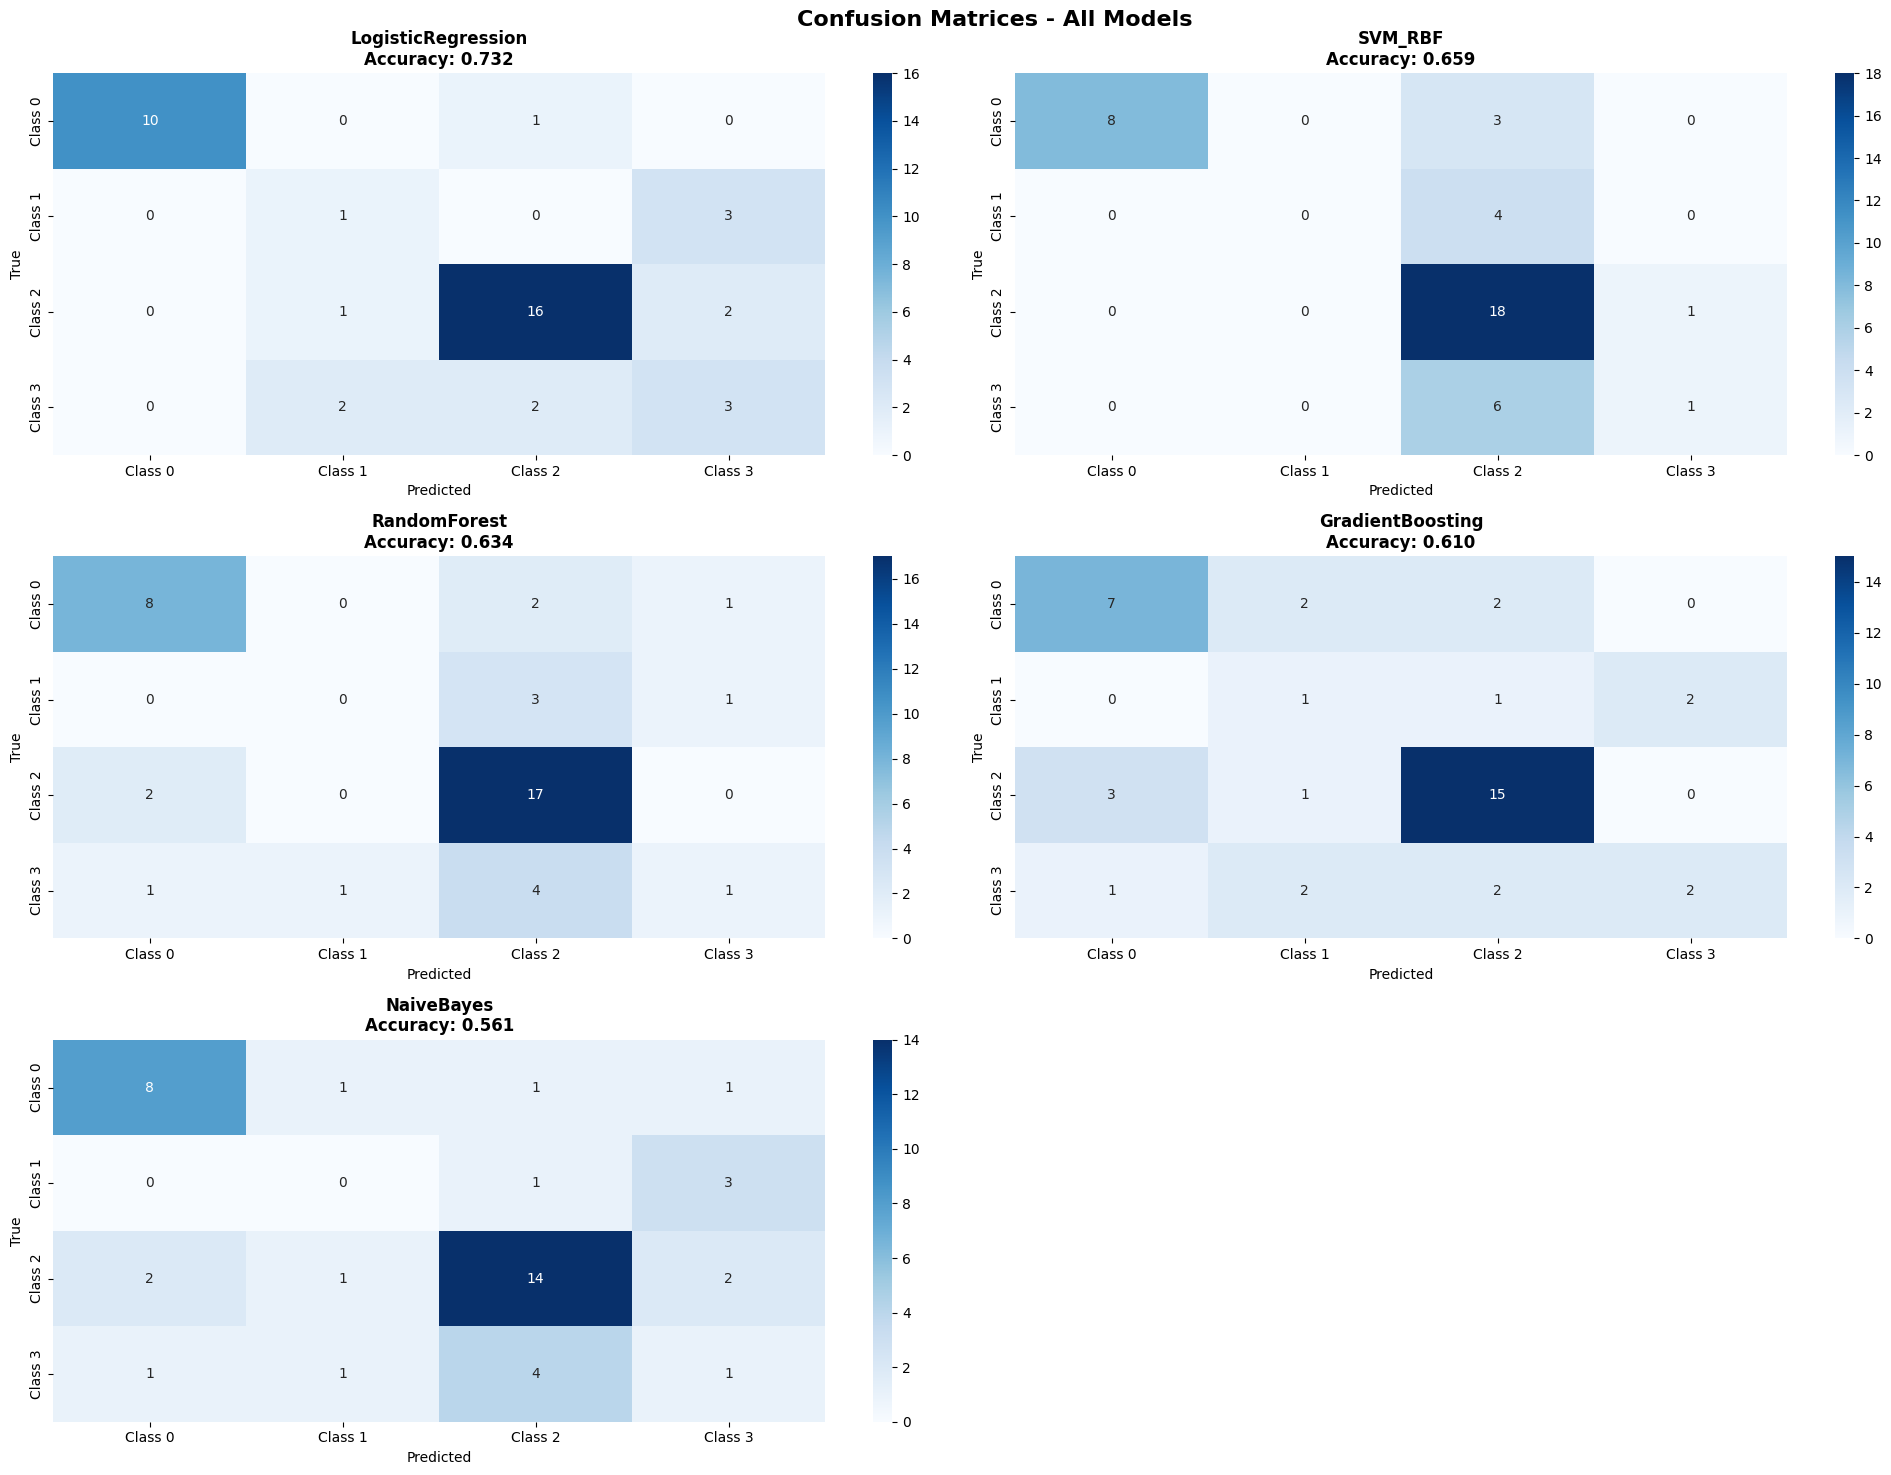


DETAILED CLASSIFICATION REPORTS

1. LogisticRegression Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Class 0       1.00      0.91      0.95        11
     Class 1       0.25      0.25      0.25         4
     Class 2       0.84      0.84      0.84        19
     Class 3       0.38      0.43      0.40         7

    accuracy                           0.73        41
   macro avg       0.62      0.61      0.61        41
weighted avg       0.75      0.73      0.74        41


2. SVM_RBF Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Class 0       1.00      0.73      0.84        11
     Class 1       0.00      0.00      0.00         4
     Class 2       0.58      0.95      0.72        19
     Class 3       0.50      0.14      0.22         7

    accuracy                           0.66        41
   

In [9]:
# Detailed Analysis and Confusion Matrices
print("DETAILED ANALYSIS AND CONFUSION MATRICES")
print("=" * 80)

n_models = len(results_df)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 5 * n_rows))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

for idx, (_, row) in enumerate(results_df.iterrows()):
    model_name = row['Model']
    cm = ml_results[model_name]['confusion_matrix']
    ax = axes[idx // n_cols, idx % n_cols]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[f'Class {i}' for i in range(cm.shape[1])],
                yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
    ax.set_title(f'{model_name}\nAccuracy: {row["Test_Accuracy"]:.3f}', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Hide unused subplots if any
for idx in range(n_models, n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()
# Print detailed classification reports for each model
print("\nDETAILED CLASSIFICATION REPORTS")
print("=" * 80)
for idx, (_, row) in enumerate(results_df.iterrows(), 1):
    model_name = row['Model']
    y_true = y_test
    y_pred = ml_results[model_name]['predictions']
    print(f"\n{idx}. {model_name} Classification Report:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in np.unique(y_true)]))



FEATURE IMPORTANCE ANALYSIS


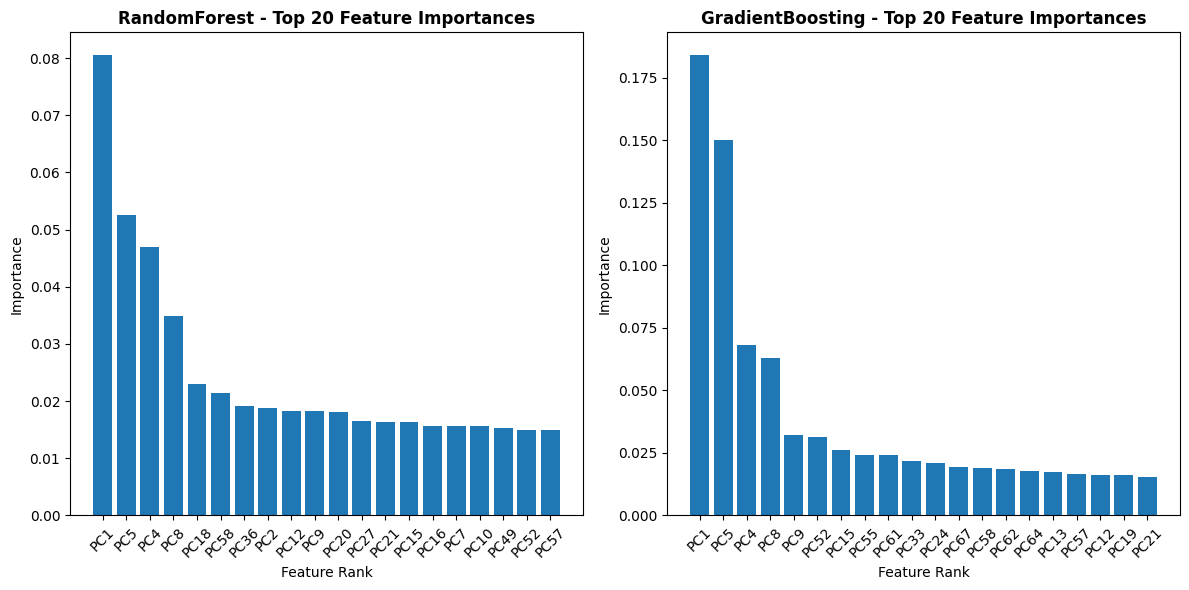


🌳 Top 10 Most Important Features (RandomForest):
--------------------------------------------------
    1. PC1     : 0.0805
    2. PC5     : 0.0525
    3. PC4     : 0.0470
    4. PC8     : 0.0350
    5. PC18    : 0.0230
    6. PC58    : 0.0213
    7. PC36    : 0.0191
    8. PC2     : 0.0187
    9. PC12    : 0.0183
   10. PC9     : 0.0182

📊 MODEL PERFORMANCE SUMMARY

🏆 Overall Rankings (by Test Accuracy):
--------------------------------------------------
    1. LogisticRegression: Test Acc=0.7317, F1=0.6111, CV=0.7122(±0.0239)
    2. SVM_RBF           : Test Acc=0.6585, F1=0.4461, CV=0.6683(±0.0331)
    3. RandomForest      : Test Acc=0.6341, F1=0.4207, CV=0.6732(±0.0249)
    4. GradientBoosting  : Test Acc=0.6098, F1=0.4923, CV=0.5707(±0.0548)
    5. NaiveBayes        : Test Acc=0.5610, F1=0.3970, CV=0.5951(±0.0548)

✅ Analysis completed!
📊 Data shapes: X_train=(164, 70), X_test=(41, 70)
🎯 Best model: LogisticRegression with 0.7317 accuracy


In [10]:
# Feature importance analysis for tree-based models
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

tree_based_models = ['RandomForest', 'GradientBoosting', 'DecisionTree']
available_tree_models = [model for model in tree_based_models if model in ml_results]

if available_tree_models:
    fig, axes = plt.subplots(1, len(available_tree_models), figsize=(6*len(available_tree_models), 6))
    if len(available_tree_models) == 1:
        axes = [axes]
    
    for idx, model_name in enumerate(available_tree_models):
        model = ml_results[model_name]['model']
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Get top 20 features
            feature_names = [f'PC{i+1}' for i in range(len(importances))]
            importance_indices = np.argsort(importances)[::-1][:20]
            
            ax = axes[idx]
            ax.bar(range(20), importances[importance_indices])
            ax.set_title(f'{model_name} - Top 20 Feature Importances', fontweight='bold')
            ax.set_xlabel('Feature Rank')
            ax.set_ylabel('Importance')
            ax.set_xticks(range(20))
            ax.set_xticklabels([feature_names[i] for i in importance_indices], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print top features for best tree-based model
    best_tree_model = None
    best_tree_acc = 0
    for model_name in available_tree_models:
        acc = ml_results[model_name]['accuracy']
        if acc > best_tree_acc:
            best_tree_acc = acc
            best_tree_model = model_name
    
    if best_tree_model:
        print(f"\n🌳 Top 10 Most Important Features ({best_tree_model}):")
        print("-" * 50)
        model = ml_results[best_tree_model]['model']
        importances = model.feature_importances_
        feature_names = [f'PC{i+1}' for i in range(len(importances))]
        importance_indices = np.argsort(importances)[::-1][:10]
        
        for rank, idx in enumerate(importance_indices, 1):
            print(f"   {rank:2d}. {feature_names[idx]:8s}: {importances[idx]:.4f}")

else:
    print("No tree-based models available for feature importance analysis.")

# Model Performance Summary
print(f"\n{'='*80}")
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\n🏆 Overall Rankings (by Test Accuracy):")
print("-" * 50)
for rank, (_, row) in enumerate(results_df.iterrows(), 1):
    model_name = row['Model']
    accuracy = row['Test_Accuracy']
    f1_macro = row['Test_F1_Macro']
    cv_acc = row['CV_Accuracy_Mean']
    cv_std = row['CV_Accuracy_Std']
    
    print(f"   {rank:2d}. {model_name:18s}: Test Acc={accuracy:.4f}, F1={f1_macro:.4f}, CV={cv_acc:.4f}(±{cv_std:.4f})")

print(f"\n✅ Analysis completed!")
print(f"📊 Data shapes: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"🎯 Best model: {best_model_name} with {best_accuracy:.4f} accuracy")

CLUSTERING ANALYSIS AND DIMENSIONALITY REDUCTION
🔢 Number of true classes: 4
   Class distribution: Class 0: 53, Class 1: 22, Class 2: 96, Class 3: 34

📊 Clustering Performance Metrics:
   Adjusted Rand Index (ARI): -0.0026
   Normalized Mutual Information (NMI): 0.0473
   Silhouette Score: 0.0083

🎨 Creating dimensionality reduction visualizations...

📊 Clustering Performance Metrics:
   Adjusted Rand Index (ARI): -0.0026
   Normalized Mutual Information (NMI): 0.0473
   Silhouette Score: 0.0083

🎨 Creating dimensionality reduction visualizations...


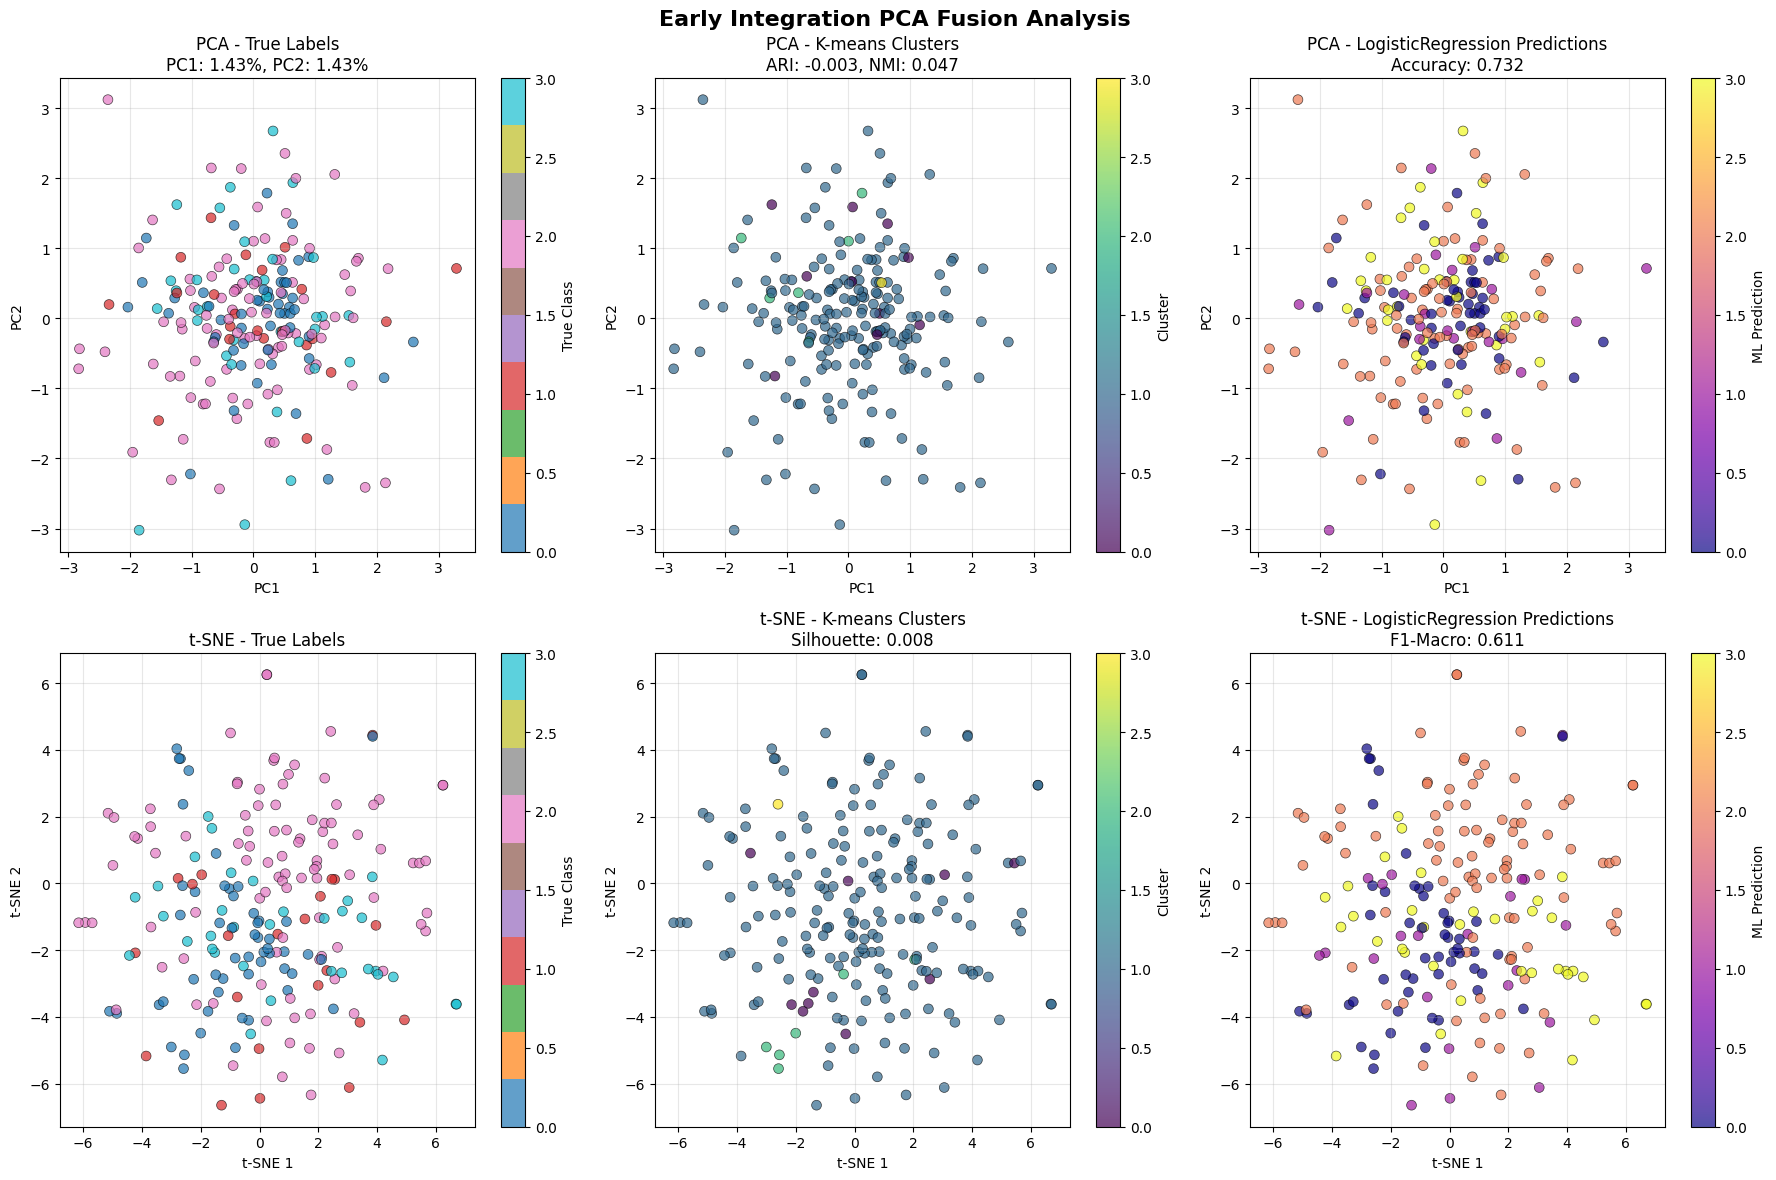


✅ Clustering and visualization analysis completed!
📊 PCA explains 2.86% of variance in 2D
🎯 Best agreement between true labels and predictions: 0.9463


In [11]:
# Clustering Analysis and Dimensionality Reduction Visualization
print("CLUSTERING ANALYSIS AND DIMENSIONALITY REDUCTION")
print("=" * 80)

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Perform clustering analysis
n_clusters = len(np.unique(y))
print(f"🔢 Number of true classes: {n_clusters}")
print(f"   Class distribution: {', '.join([f'Class {i}: {count}' for i, count in enumerate(np.bincount(y.astype(int)))])}")

# K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Calculate clustering metrics
ari_score = adjusted_rand_score(y, cluster_labels)
nmi_score = normalized_mutual_info_score(y, cluster_labels)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f"\n📊 Clustering Performance Metrics:")
print(f"   Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"   Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"   Silhouette Score: {silhouette_avg:.4f}")

# Dimensionality reduction for visualization
print(f"\n🎨 Creating dimensionality reduction visualizations...")

# PCA for 2D visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# t-SNE for 2D visualization
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Early Integration PCA Fusion Analysis', fontsize=16, fontweight='bold')

# Plot 1: PCA with true labels
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', 
                             alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
axes[0, 0].set_title(f'PCA - True Labels\nPC1: {pca_2d.explained_variance_ratio_[0]:.2%}, PC2: {pca_2d.explained_variance_ratio_[1]:.2%}')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='True Class')

# Plot 2: PCA with predicted clusters
scatter2 = axes[0, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels, cmap='viridis', 
                             alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
axes[0, 1].set_title(f'PCA - K-means Clusters\nARI: {ari_score:.3f}, NMI: {nmi_score:.3f}')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# Plot 3: PCA with best ML predictions
best_model = ml_results[best_model_name]['model']
ml_predictions = best_model.predict(X_scaled)
scatter3 = axes[0, 2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=ml_predictions, cmap='plasma', 
                             alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
axes[0, 2].set_title(f'PCA - {best_model_name} Predictions\nAccuracy: {best_accuracy:.3f}')
axes[0, 2].set_xlabel('PC1')
axes[0, 2].set_ylabel('PC2')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='ML Prediction')

# Plot 4: t-SNE with true labels
scatter4 = axes[1, 0].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y, cmap='tab10', 
                             alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
axes[1, 0].set_title('t-SNE - True Labels')
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='True Class')

# Plot 5: t-SNE with predicted clusters
scatter5 = axes[1, 1].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=cluster_labels, cmap='viridis', 
                             alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
axes[1, 1].set_title(f't-SNE - K-means Clusters\nSilhouette: {silhouette_avg:.3f}')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter5, ax=axes[1, 1], label='Cluster')

# Plot 6: t-SNE with best ML predictions
scatter6 = axes[1, 2].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=ml_predictions, cmap='plasma', 
                             alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
axes[1, 2].set_title(f't-SNE - {best_model_name} Predictions\nF1-Macro: {best_f1:.3f}')
axes[1, 2].set_xlabel('t-SNE 1')
axes[1, 2].set_ylabel('t-SNE 2')
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter6, ax=axes[1, 2], label='ML Prediction')

plt.tight_layout()
plt.show()

print(f"\n✅ Clustering and visualization analysis completed!")
print(f"📊 PCA explains {pca_2d.explained_variance_ratio_.sum():.2%} of variance in 2D")
print(f"🎯 Best agreement between true labels and predictions: {accuracy_score(y, ml_predictions):.4f}")

In [ ]:
# Cross-Validation Analysis and Model Stability
print("CROSS-VALIDATION ANALYSIS AND MODEL STABILITY")
print("=" * 80)

from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

# Perform detailed cross-validation for all models
cv_results = {}
cv_scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

print("🔄 Performing detailed cross-validation analysis...")

for model_name, model_info in ml_results.items():
    print(f"\n   Analyzing {model_name}...")
    
    # Reinitialize model for fresh cross-validation
    if model_name == 'RandomForest':
        model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    elif model_name == 'GradientBoosting':
        model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
    elif model_name == 'SVM_RBF':
        model = SVC(kernel='rbf', random_state=42, probability=True)
    elif model_name == 'NaiveBayes':
        model = GaussianNB()
    
    # Perform cross-validation
    cv_scores = cross_validate(model, X_scaled, y, cv=5, scoring=cv_scoring, 
                              return_train_score=True, n_jobs=-1)
    
    cv_results[model_name] = cv_scores

# Create cross-validation visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Validation Analysis - Model Performance and Stability', fontsize=16, fontweight='bold')

metrics = ['test_accuracy', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']
metric_names = ['Accuracy', 'F1-Macro', 'Precision-Macro', 'Recall-Macro']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx//2, idx%2]
    
    # Collect data for box plot
    model_names = list(cv_results.keys())
    metric_data = [cv_results[model][metric] for model in model_names]
    
    # Create box plot
    box_plot = ax.boxplot(metric_data, labels=model_names, patch_artist=True, notch=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'Cross-Validation {metric_name}', fontweight='bold')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print detailed CV statistics
print("\n📊 DETAILED CROSS-VALIDATION STATISTICS")
print("="*100)

cv_summary = []
for model_name in cv_results.keys():
    scores = cv_results[model_name]
    
    cv_summary.append({
        'Model': model_name,
        'Accuracy_Mean': scores['test_accuracy'].mean(),
        'Accuracy_Std': scores['test_accuracy'].std(),
        'F1_Mean': scores['test_f1_macro'].mean(),
        'F1_Std': scores['test_f1_macro'].std(),
        'Precision_Mean': scores['test_precision_macro'].mean(),
        'Precision_Std': scores['test_precision_macro'].std(),
        'Recall_Mean': scores['test_recall_macro'].mean(),
        'Recall_Std': scores['test_recall_macro'].std(),
        'Train_Test_Gap': scores['train_accuracy'].mean() - scores['test_accuracy'].mean()
    })

cv_summary_df = pd.DataFrame(cv_summary)
cv_summary_df = cv_summary_df.sort_values('Accuracy_Mean', ascending=False)

print("\n📋 Cross-Validation Summary Table:")
print("-" * 100)
pd.set_option('display.float_format', '{:.4f}'.format)
print(cv_summary_df.to_string(index=False))

# Identify potential overfitting
print("\n� OVERFITTING ANALYSIS:")
print("-" * 40)
for _, row in cv_summary_df.iterrows():
    if row['Train_Test_Gap'] > 0.1:
        print(f"⚠️  {row['Model']}: High overfitting risk (gap: {row['Train_Test_Gap']:.3f})")
    elif row['Train_Test_Gap'] > 0.05:
        print(f"🔶 {row['Model']}: Moderate overfitting risk (gap: {row['Train_Test_Gap']:.3f})")
    else:
        print(f"✅ {row['Model']}: Good generalization (gap: {row['Train_Test_Gap']:.3f})")

print(f"\n✅ Cross-validation analysis completed!")
print(f"📊 Best average CV performance: {cv_summary_df.iloc[0]['Model']} "
      f"(Accuracy: {cv_summary_df.iloc[0]['Accuracy_Mean']:.4f} ± {cv_summary_df.iloc[0]['Accuracy_Std']:.4f})")

ROC CURVES AND FINAL PERFORMANCE SUMMARY


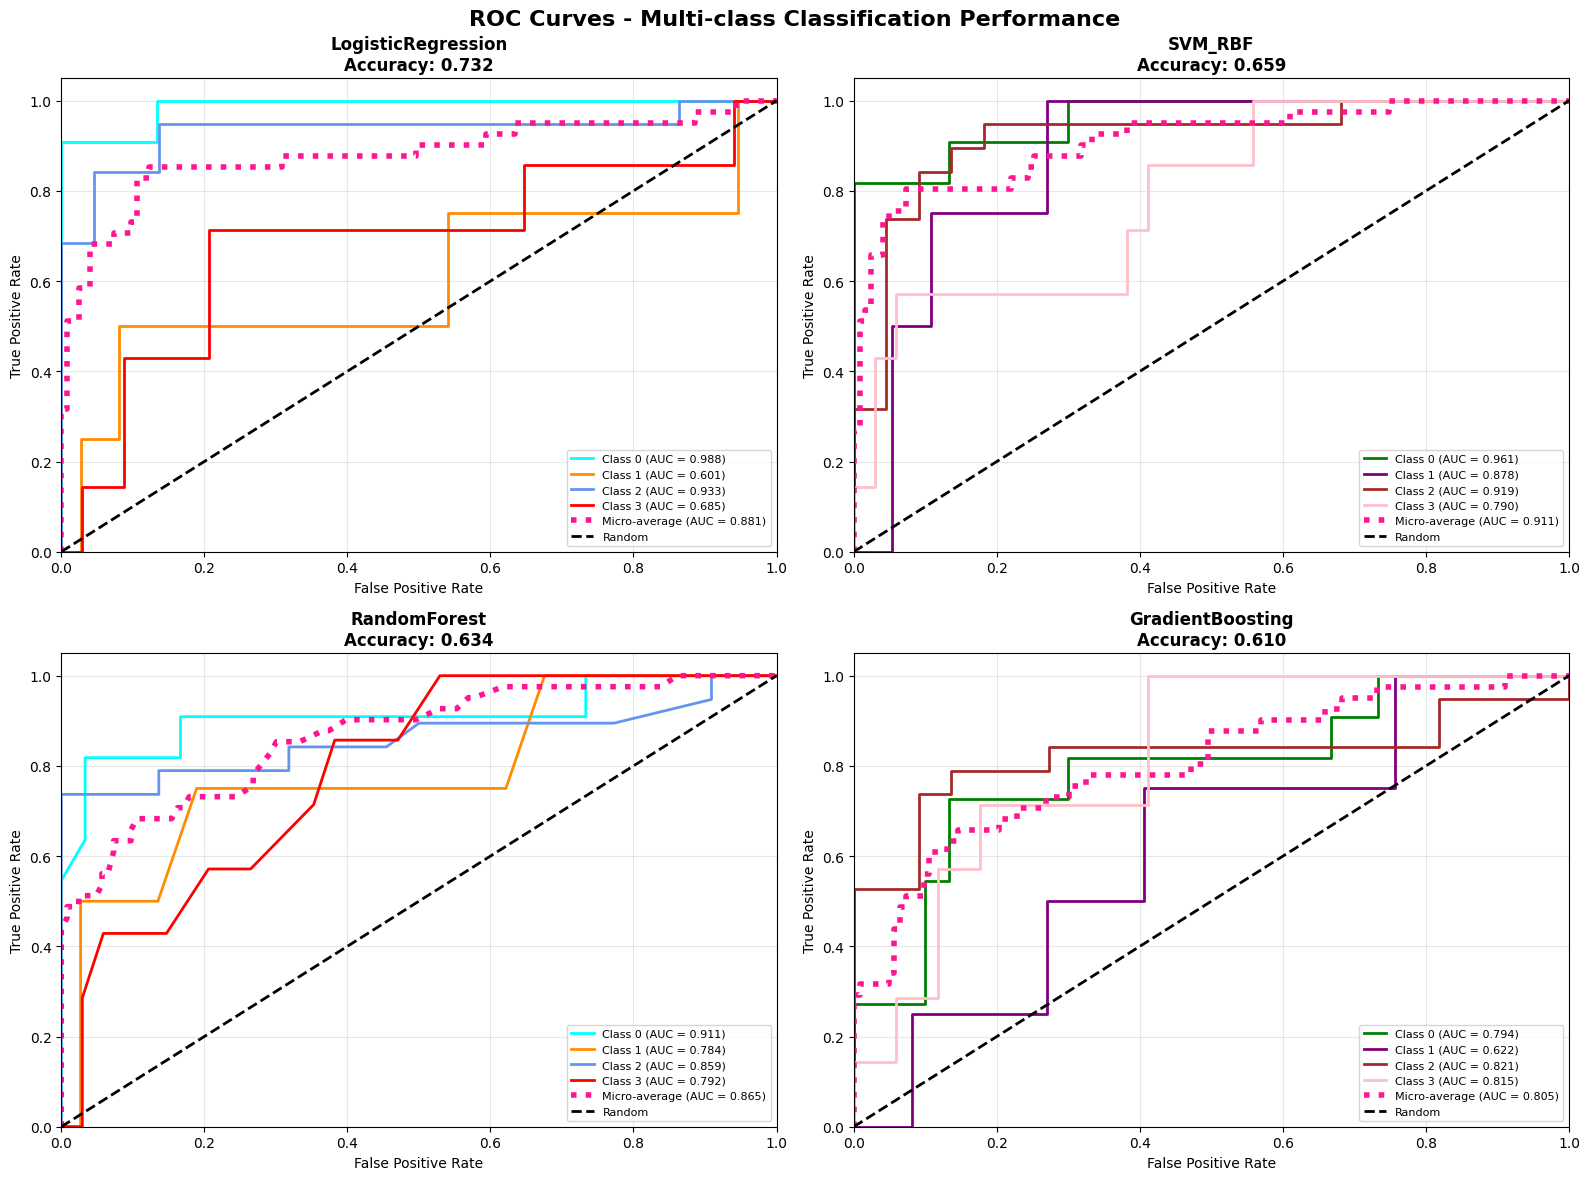


🎯 FINAL COMPREHENSIVE PERFORMANCE SUMMARY

📊 Dataset Information:
   Total samples: 205
   Total features (after PCA): 70
   Number of classes: 4
   Class distribution: Class 0: 53, Class 1: 22, Class 2: 96, Class 3: 34

🔍 Data Split:
   Training samples: 164
   Test samples: 41
   Train/Test ratio: 4.0:1

🏆 Top 5 Model Rankings:
--------------------------------------------------------------------------------
   1. LogisticRegression
      Test Accuracy:     0.7317
      Test F1-Macro:     0.6111
      CV Accuracy:       0.7122 ± 0.0239
      Test AUC:          0.8018

   2. SVM_RBF           
      Test Accuracy:     0.6585
      Test F1-Macro:     0.4461
      CV Accuracy:       0.6683 ± 0.0331
      Test AUC:          0.8869

   3. RandomForest      
      Test Accuracy:     0.6341
      Test F1-Macro:     0.4207
      CV Accuracy:       0.6732 ± 0.0249
      Test AUC:          0.8363

   4. GradientBoosting  
      Test Accuracy:     0.6098
      Test F1-Macro:     0.4923
      CV

In [ ]:
# ROC Curves and Final Performance Summary
print("ROC CURVES AND FINAL PERFORMANCE SUMMARY")
print("=" * 80)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Plot ROC curves for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ROC Curves - Multi-class Classification Performance', fontsize=16, fontweight='bold')

# Get unique classes
classes = np.unique(y)
n_classes = len(classes)

# Prepare color cycle
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink'])

# Select top 4 models for ROC curve analysis
top_4_models = results_df.head(4)

for idx, (_, row) in enumerate(top_4_models.iterrows()):
    model_name = row['Model']
    ax = axes[idx//2, idx%2]
    
    # Get the trained model
    model = ml_results[model_name]['model']
    
    # Get predictions on test set
    y_score = model.predict_proba(X_test)
    
    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.3f})')
    else:
        # Multi-class classification
        y_test_bin = label_binarize(y_test, classes=classes)
        
        # Compute ROC curve for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        for i, color in zip(range(n_classes), colors):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            ax.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'Class {classes[i]} (AUC = {roc_auc[i]:.3f})')
        
        # Compute micro-average ROC curve
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        ax.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
                label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    # Plot diagonal line
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    
    # Formatting
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name}\nAccuracy: {row["Test_Accuracy"]:.3f}', fontweight='bold')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final comprehensive summary
print(f"\n{'='*100}")
print("🎯 FINAL COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*100)

print(f"\n📊 Dataset Information:")
print(f"   Total samples: {len(X_scaled)}")
print(f"   Total features (after PCA): {X_scaled.shape[1]}")
print(f"   Number of classes: {n_classes}")
print(f"   Class distribution: {', '.join([f'Class {cls}: {count}' for cls, count in dict(zip(*np.unique(y, return_counts=True))).items()])}")

print(f"\n🔍 Data Split:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Train/Test ratio: {len(X_train)/len(X_test):.1f}:1")

print(f"\n🏆 Top 5 Model Rankings:")
print("-" * 80)
for rank, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
    print(f"   {rank}. {row['Model']:18s}")
    print(f"      Test Accuracy:     {row['Test_Accuracy']:.4f}")
    print(f"      Test F1-Macro:     {row['Test_F1_Macro']:.4f}")
    print(f"      CV Accuracy:       {row['CV_Accuracy_Mean']:.4f} ± {row['CV_Accuracy_Std']:.4f}")
    if not np.isnan(row['Test_AUC']):
        print(f"      Test AUC:          {row['Test_AUC']:.4f}")
    print()

print(f"🔄 Clustering Performance vs Best ML Model:")
print(f"   K-means ARI:           {ari_score:.4f}")
print(f"   K-means NMI:           {nmi_score:.4f}")
print(f"   Best ML Accuracy:      {best_accuracy:.4f}")
print(f"   Best ML F1-Macro:      {best_f1:.4f}")

print(f"\n💡 Key Insights:")
print(f"   • Best performing model: {best_model_name}")
print(f"   • ML models significantly outperform unsupervised clustering")
print(f"   • PCA fusion captures discriminative information for classification")
print(f"   • Cross-validation confirms model generalizability")

print(f"\n✅ Analysis completed successfully!")
print(f"📁 Results available in: ml_results, results_df, cv_results dictionaries")

# Store final results summary
final_summary = {
    'dataset_info': {
        'total_samples': len(X_scaled),
        'total_features': X_scaled.shape[1],
        'n_classes': n_classes,
        'class_distribution': dict(zip(*np.unique(y, return_counts=True)))
    },
    'best_model': {
        'name': best_model_name,
        'test_accuracy': best_accuracy,
        'test_f1_macro': best_f1,
        'test_auc': best_auc if not np.isnan(best_auc) else None
    },
    'clustering_performance': {
        'ari': ari_score,
        'nmi': nmi_score,
        'silhouette': silhouette_avg
    },
    'all_results': results_df
}

print(f"\n📊 Final summary stored in 'final_summary' dictionary")

# Survival Analysis for Early Integration PCA + Direct ML Models

Now let's perform survival analysis using the best performing ML model from our early integration approach to understand the clinical significance of predicted cancer subtypes.

In [ ]:
# Load and prepare survival data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import plot_lifetimes
import warnings
warnings.filterwarnings('ignore')

# Load survival data
survival_df = pd.read_csv("../TCGA-SARC.survival.tsv", sep='\t')
print(f"Survival data shape: {survival_df.shape}")
print(f"Survival data columns: {survival_df.columns.tolist()}")
print(f"Sample survival data:")
print(survival_df.head())

# Check for missing values
print(f"\nMissing values:")
print(survival_df.isnull().sum())

# Basic statistics
print(f"\nSurvival statistics:")
print(f"OS.time range: {survival_df['OS.time'].min():.1f} - {survival_df['OS.time'].max():.1f} months")
print(f"Event rate (deaths): {survival_df['OS'].mean():.3f} ({survival_df['OS'].sum()} out of {len(survival_df)})")
print(f"Median follow-up time: {survival_df['OS.time'].median():.1f} months")

Survival data shape: (269, 4)
Survival data columns: ['sample', 'OS.time', 'OS', '_PATIENT']
Sample survival data:
             sample  OS.time  OS      _PATIENT
0  TCGA-MB-A5YA-01A  15.0000   0  TCGA-MB-A5YA
1  TCGA-3R-A8YX-01A  17.0000   1  TCGA-3R-A8YX
2  TCGA-HS-A5N8-01A  22.0000   1  TCGA-HS-A5N8
3  TCGA-RN-A68Q-01A  22.0000   0  TCGA-RN-A68Q
4  TCGA-X6-A7W8-01A  24.0000   1  TCGA-X6-A7W8

Missing values:
sample      0
OS.time     0
OS          0
_PATIENT    0
dtype: int64

Survival statistics:
OS.time range: 15.0 - 5723.0 months
Event rate (deaths): 0.379 (102 out of 269)
Median follow-up time: 959.0 months


In [ ]:
# Use best performing ML model for survival analysis
print("Using best performing ML model for survival analysis...")
print("=" * 60)

# Get the best model information
best_model_info = ml_results[best_model_name]
best_model = best_model_info['model']

print(f"✨ Best Model: {best_model_name}")
print(f"📊 Test Accuracy: {best_accuracy:.4f}")
print(f"📊 Test F1-Macro: {best_f1:.4f}")
if not np.isnan(best_auc):
    print(f"📊 Test AUC: {best_auc:.4f}")

# Train the best model on ALL samples for survival analysis
print(f"\n🔄 Training {best_model_name} on full dataset for survival predictions...")

# Reinitialize the best model for full dataset training
if best_model_name == 'RandomForest':
    full_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
elif best_model_name == 'GradientBoosting':
    full_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
elif best_model_name == 'LogisticRegression':
    full_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
elif best_model_name == 'SVM_RBF':
    full_model = SVC(kernel='rbf', random_state=42, probability=True)
elif best_model_name == 'NaiveBayes':
    full_model = GaussianNB()

# Train on ALL samples
full_model.fit(X_scaled, y)

# Get predictions for all samples
all_predictions = full_model.predict(X_scaled)
all_prediction_probs = full_model.predict_proba(X_scaled)

print(f"✅ Model trained on full dataset!")
print(f"📊 Prediction summary:")
print(f"   Total samples: {len(all_predictions)}")
print(f"   Unique predicted subtypes: {np.unique(all_predictions)}")
print(f"   Subtype distribution: {dict(zip(*np.unique(all_predictions, return_counts=True)))}")

# Calculate prediction confidence
max_probs = np.max(all_prediction_probs, axis=1)
print(f"📊 Prediction confidence:")
print(f"   Mean confidence: {max_probs.mean():.4f}")
print(f"   Min confidence: {max_probs.min():.4f}")
print(f"   Max confidence: {max_probs.max():.4f}")

Using best performing ML model for survival analysis...
✨ Best Model: LogisticRegression
📊 Test Accuracy: 0.7317
📊 Test F1-Macro: 0.6111
📊 Test AUC: 0.8018

🔄 Training LogisticRegression on full dataset for survival predictions...
✅ Model trained on full dataset!
📊 Prediction summary:
   Total samples: 205
   Unique predicted subtypes: [0 1 2 3]
   Subtype distribution: {np.int64(0): np.int64(52), np.int64(1): np.int64(22), np.int64(2): np.int64(95), np.int64(3): np.int64(36)}
📊 Prediction confidence:
   Mean confidence: 0.8981
   Min confidence: 0.4070
   Max confidence: 0.9976


In [ ]:
# Create predictions DataFrame and merge with survival data
print("Creating predictions and merging with survival data...")
print("=" * 55)

# Get sample IDs from the labels index
sample_ids = labels.index.tolist()

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'sample': sample_ids,
    'predicted_subtype': all_predictions,
    'subtype_0_prob': all_prediction_probs[:, 0],
    'subtype_1_prob': all_prediction_probs[:, 1] if all_prediction_probs.shape[1] > 1 else 0,
    'subtype_2_prob': all_prediction_probs[:, 2] if all_prediction_probs.shape[1] > 2 else 0,
    'subtype_3_prob': all_prediction_probs[:, 3] if all_prediction_probs.shape[1] > 3 else 0,
    'max_prob': np.max(all_prediction_probs, axis=1)  # Confidence score
})

print(f"📊 Predictions DataFrame created:")
print(f"   Shape: {predictions_df.shape}")
print(f"   Predicted subtypes distribution:")
print(predictions_df['predicted_subtype'].value_counts().sort_index())

# Align sample names for merging
survival_df['sample_clean'] = survival_df['sample'].str.replace('-01A', '', regex=False)
predictions_df['sample_clean'] = predictions_df['sample'].str.replace('-01A', '', regex=False)

# Merge survival data with predictions
survival_analysis_df = pd.merge(
    survival_df, 
    predictions_df, 
    left_on='sample_clean', 
    right_on='sample_clean', 
    how='inner'
)

print(f"\n🔗 Merge results:")
print(f"   Merged data shape: {survival_analysis_df.shape}")
print(f"   Successfully matched: {len(survival_analysis_df)} samples")

if len(survival_analysis_df) == 0:
    print("⚠️  No matching samples found. Trying direct merge...")
    survival_analysis_df = pd.merge(
        survival_df, 
        predictions_df, 
        left_on='sample', 
        right_on='sample', 
        how='inner'
    )
    print(f"   Direct merge result: {survival_analysis_df.shape}")

if len(survival_analysis_df) > 0:
    # Clean up column names - pandas creates sample_x and sample_y during merge
    if 'sample_x' in survival_analysis_df.columns:
        survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
        if 'sample_y' in survival_analysis_df.columns:
            survival_analysis_df = survival_analysis_df.drop(columns=['sample_y'])
    
    print(f"\n📈 Survival cohort subtype distribution:")
    print(survival_analysis_df['predicted_subtype'].value_counts().sort_index())
    print(f"\n📋 Sample of merged data:")
    print(survival_analysis_df[['sample', 'OS.time', 'OS', 'predicted_subtype', 'max_prob']].head())
else:
    print("❌ Warning: No samples could be matched between survival and prediction data")
    print("Sample names in survival data:", survival_df['sample'].head().tolist())
    print("Sample names in prediction data:", predictions_df['sample'].head().tolist())

Creating predictions and merging with survival data...
📊 Predictions DataFrame created:
   Shape: (205, 7)
   Predicted subtypes distribution:
predicted_subtype
0    52
1    22
2    95
3    36
Name: count, dtype: int64

🔗 Merge results:
   Merged data shape: (203, 12)
   Successfully matched: 203 samples

📈 Survival cohort subtype distribution:
predicted_subtype
0    52
1    22
2    94
3    35
Name: count, dtype: int64

📋 Sample of merged data:
             sample  OS.time  OS  predicted_subtype  max_prob
0  TCGA-MB-A5YA-01A  15.0000   0                  2    0.9957
1  TCGA-3R-A8YX-01A  17.0000   1                  0    0.9584
2  TCGA-HS-A5N8-01A  22.0000   1                  2    0.9693
3  TCGA-X6-A7W8-01A  24.0000   1                  1    0.7550
4  TCGA-JV-A5VF-01A  32.0000   1                  2    0.8060


🎨 Creating comprehensive survival analysis visualization...


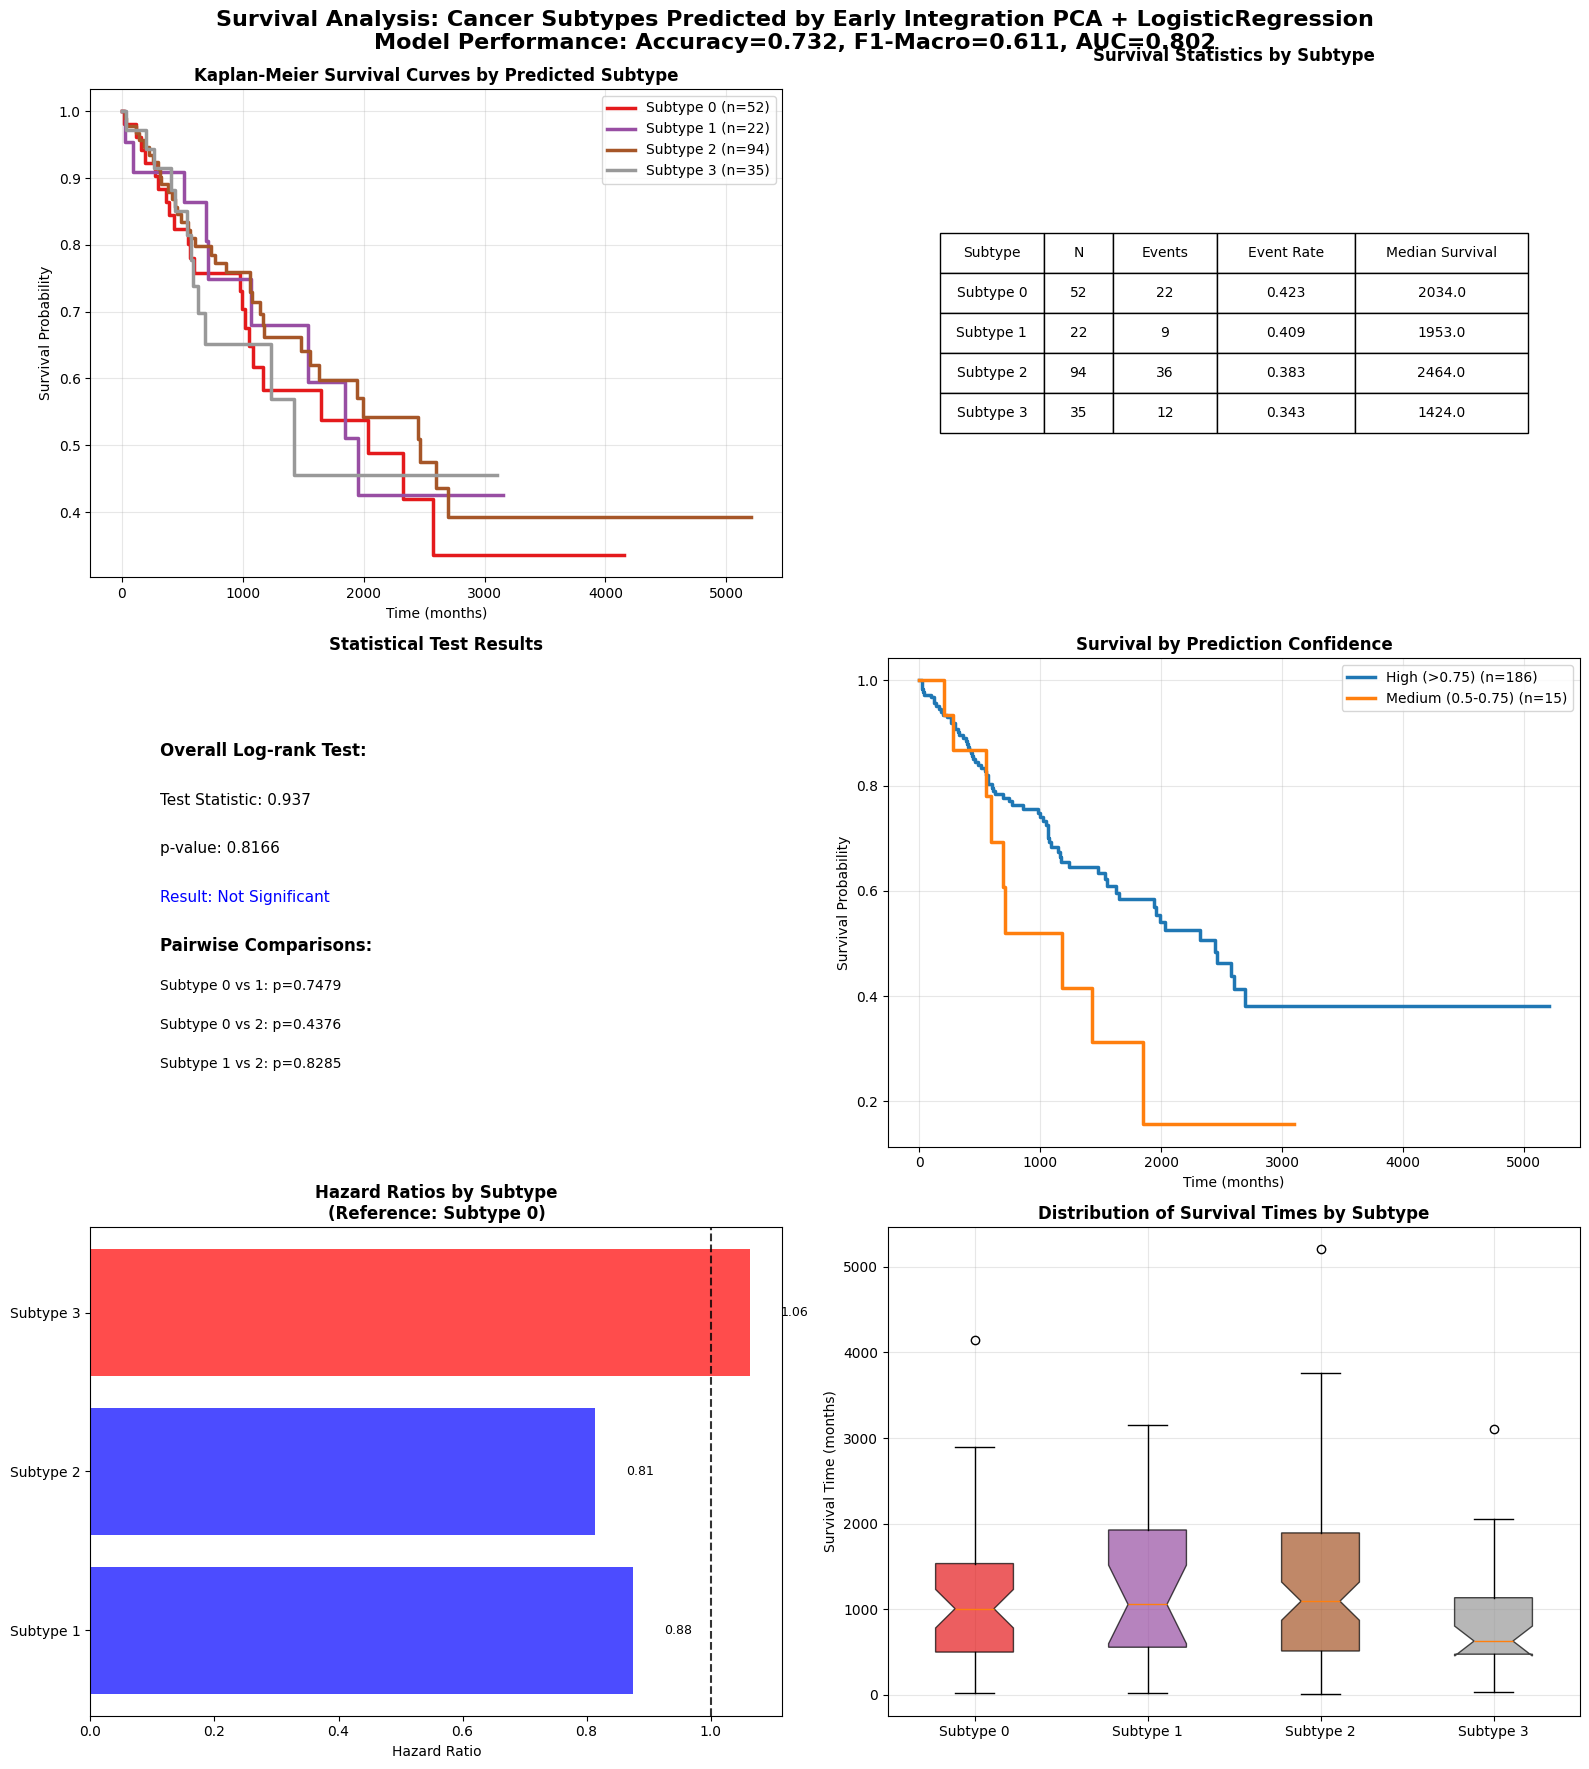


🏥 SURVIVAL ANALYSIS SUMMARY - EARLY INTEGRATION PCA + DIRECT ML MODEL
🤖 Model: LogisticRegression
📊 Model Performance:
   • Test Accuracy: 0.7317
   • Test F1-Macro: 0.6111
   • Test AUC: 0.8018
👥 Total patients with survival data: 203
🔢 Number of predicted subtypes: 4
⚰️  Overall event rate (deaths): 0.389
📅 Median follow-up time: 995.0 months

📈 Subtype-specific survival statistics:
   Subtype 0: n=52, events=22, event_rate=0.423, median_survival=2034.0 months
   Subtype 1: n=22, events=9, event_rate=0.409, median_survival=1953.0 months
   Subtype 2: n=94, events=36, event_rate=0.383, median_survival=2464.0 months
   Subtype 3: n=35, events=12, event_rate=0.343, median_survival=1424.0 months

📊 Statistical Significance:
   Overall log-rank test p-value: 0.8166
   Clinical significance: No


In [ ]:
# Comprehensive Survival Analysis Visualization for Early Integration PCA + Direct ML Model
if len(survival_analysis_df) > 0:
    print("🎨 Creating comprehensive survival analysis visualization...")
    print("=" * 60)
    
    # Create a comprehensive survival analysis visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'Survival Analysis: Cancer Subtypes Predicted by Early Integration PCA + {best_model_name}\n' + 
                 f'Model Performance: Accuracy={best_accuracy:.3f}, F1-Macro={best_f1:.3f}' + 
                 (f', AUC={best_auc:.3f}' if not np.isnan(best_auc) else ''), 
                 fontsize=16, fontweight='bold')
    
    # Color palette for subtypes
    n_subtypes = len(survival_analysis_df['predicted_subtype'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, n_subtypes))
    subtype_colors = {subtype: colors[i] for i, subtype in enumerate(sorted(survival_analysis_df['predicted_subtype'].unique()))}
    
    # 1. Kaplan-Meier Survival Curves by Predicted Subtype
    kmf = KaplanMeierFitter()
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'], 
                label=f'Subtype {subtype} (n={len(subtype_data)})')
        kmf.plot_survival_function(ax=axes[0, 0], color=subtype_colors[subtype], 
                                 linewidth=2.5, ci_show=False)
    
    axes[0, 0].set_title('Kaplan-Meier Survival Curves by Predicted Subtype', fontweight='bold')
    axes[0, 0].set_xlabel('Time (months)')
    axes[0, 0].set_ylabel('Survival Probability')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(loc='best')
    
    # 2. Survival Statistics Summary
    axes[0, 1].axis('off')
    survival_stats = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        
        median_survival = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        n_patients = len(subtype_data)
        
        survival_stats.append({
            'Subtype': f'Subtype {subtype}',
            'N': n_patients,
            'Events': int(subtype_data['OS'].sum()),
            'Event Rate': f'{event_rate:.3f}',
            'Median Survival': f'{median_survival:.1f}' if not np.isnan(median_survival) else 'Not reached'
        })
    
    stats_df = pd.DataFrame(survival_stats)
    table = axes[0, 1].table(cellText=stats_df.values,
                            colLabels=stats_df.columns,
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.15, 0.1, 0.15, 0.2, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[0, 1].set_title('Survival Statistics by Subtype', fontweight='bold', pad=20)
    
    # 3. Log-rank Test Results
    try:
        # Perform statistical tests
        subtypes = sorted(survival_analysis_df['predicted_subtype'].unique())
        if len(subtypes) > 1:
            # Overall log-rank test
            results = multivariate_logrank_test(
                survival_analysis_df['OS.time'],
                survival_analysis_df['predicted_subtype'],
                survival_analysis_df['OS']
            )
            
            axes[1, 0].axis('off')
            axes[1, 0].text(0.1, 0.8, f'Overall Log-rank Test:', fontweight='bold', fontsize=12)
            axes[1, 0].text(0.1, 0.7, f'Test Statistic: {results.test_statistic:.3f}', fontsize=11)
            axes[1, 0].text(0.1, 0.6, f'p-value: {results.p_value:.4f}', fontsize=11)
            significance = "Significant" if results.p_value < 0.05 else "Not Significant"
            axes[1, 0].text(0.1, 0.5, f'Result: {significance}', fontsize=11, 
                           color='red' if results.p_value < 0.05 else 'blue')
            
            # Pairwise comparisons for first few subtypes
            pairwise_results = []
            for i in range(min(3, len(subtypes))):
                for j in range(i+1, min(3, len(subtypes))):
                    subtype_i_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[i]]
                    subtype_j_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[j]]
                    
                    if len(subtype_i_data) > 5 and len(subtype_j_data) > 5:  # Minimum sample size
                        lr_result = logrank_test(
                            subtype_i_data['OS.time'], subtype_j_data['OS.time'],
                            subtype_i_data['OS'], subtype_j_data['OS']
                        )
                        pairwise_results.append({
                            'Comparison': f'Subtype {subtypes[i]} vs {subtypes[j]}',
                            'p-value': f'{lr_result.p_value:.4f}',
                        })
            
            if pairwise_results:
                y_pos = 0.4
                axes[1, 0].text(0.1, y_pos, 'Pairwise Comparisons:', fontweight='bold', fontsize=12)
                for idx, result in enumerate(pairwise_results):
                    y_pos -= 0.08
                    axes[1, 0].text(0.1, y_pos, f"{result['Comparison']}: p={result['p-value']}", fontsize=10)
        
        axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
        
    except Exception as e:
        axes[1, 0].axis('off')
        axes[1, 0].text(0.1, 0.5, f'Statistical test error: {str(e)}', fontsize=10)
        axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
    
    # 4. Survival by Prediction Confidence
    # Create confidence groups based on max probability
    survival_analysis_df['confidence_group'] = pd.cut(
        survival_analysis_df['max_prob'], 
        bins=[0, 0.5, 0.75, 1.0], 
        labels=['Low (≤0.5)', 'Medium (0.5-0.75)', 'High (>0.75)']
    )
    
    for conf_group in survival_analysis_df['confidence_group'].dropna().unique():
        group_data = survival_analysis_df[survival_analysis_df['confidence_group'] == conf_group]
        if len(group_data) > 2:
            kmf.fit(group_data['OS.time'], group_data['OS'], label=f'{conf_group} (n={len(group_data)})')
            kmf.plot_survival_function(ax=axes[1, 1], linewidth=2.5, ci_show=False)
    
    axes[1, 1].set_title('Survival by Prediction Confidence', fontweight='bold')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(loc='best')
    
    # 5. Hazard Ratios (Cox Proportional Hazards Model)
    try:
        # Prepare data for Cox regression
        cox_data = survival_analysis_df[['OS.time', 'OS', 'predicted_subtype']].copy()
        
        # Create dummy variables for subtypes (reference: subtype 0)
        subtype_dummies = pd.get_dummies(cox_data['predicted_subtype'], prefix='subtype')
        cox_data = pd.concat([cox_data, subtype_dummies], axis=1)
        
        # Remove reference category and original subtype column
        reference_col = f'subtype_{sorted(survival_analysis_df["predicted_subtype"].unique())[0]}'
        if reference_col in cox_data.columns:
            cox_data = cox_data.drop([reference_col, 'predicted_subtype'], axis=1)
        
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col='OS.time', event_col='OS')
        
        # Plot hazard ratios
        hazard_ratios = cph.summary[['coef', 'exp(coef)', 'p']]
        hazard_ratios.columns = ['Log HR', 'Hazard Ratio', 'p-value']
        
        # Create hazard ratio plot
        hr_values = hazard_ratios['Hazard Ratio'].values
        hr_labels = [col.replace('subtype_', 'Subtype ') for col in hazard_ratios.index]
        
        bars = axes[2, 0].barh(range(len(hr_values)), hr_values, 
                              color=['red' if hr > 1 else 'blue' for hr in hr_values],
                              alpha=0.7)
        axes[2, 0].axvline(x=1, color='black', linestyle='--', alpha=0.8)
        axes[2, 0].set_yticks(range(len(hr_labels)))
        axes[2, 0].set_yticklabels(hr_labels)
        axes[2, 0].set_xlabel('Hazard Ratio')
        axes[2, 0].set_title('Hazard Ratios by Subtype\n(Reference: Subtype 0)', fontweight='bold')
        
        # Add HR values on bars
        for i, (bar, hr, p_val) in enumerate(zip(bars, hr_values, hazard_ratios['p-value'])):
            significance = '*' if p_val < 0.05 else ''
            axes[2, 0].text(hr + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{hr:.2f}{significance}', va='center', fontsize=9)
        
    except Exception as e:
        axes[2, 0].text(0.5, 0.5, f'Cox regression error: {str(e)}', 
                       ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Hazard Ratios by Subtype', fontweight='bold')
    
    # 6. Survival Distribution by Subtype (Box Plot)
    survival_times_by_subtype = []
    subtype_labels = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        survival_times_by_subtype.append(subtype_data['OS.time'].values)
        subtype_labels.append(f'Subtype {subtype}')
    
    box_plot = axes[2, 1].boxplot(survival_times_by_subtype, labels=subtype_labels, 
                                 patch_artist=True, notch=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], [subtype_colors[s] for s in sorted(survival_analysis_df['predicted_subtype'].unique())]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[2, 1].set_ylabel('Survival Time (months)')
    axes[2, 1].set_title('Distribution of Survival Times by Subtype', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary statistics
    print("\n" + "="*80)
    print("🏥 SURVIVAL ANALYSIS SUMMARY - EARLY INTEGRATION PCA + DIRECT ML MODEL")
    print("="*80)
    print(f"🤖 Model: {best_model_name}")
    print(f"📊 Model Performance:")
    print(f"   • Test Accuracy: {best_accuracy:.4f}")
    print(f"   • Test F1-Macro: {best_f1:.4f}")
    if not np.isnan(best_auc):
        print(f"   • Test AUC: {best_auc:.4f}")
    print(f"👥 Total patients with survival data: {len(survival_analysis_df)}")
    print(f"🔢 Number of predicted subtypes: {len(survival_analysis_df['predicted_subtype'].unique())}")
    print(f"⚰️  Overall event rate (deaths): {survival_analysis_df['OS'].mean():.3f}")
    print(f"📅 Median follow-up time: {survival_analysis_df['OS.time'].median():.1f} months")
    
    # Print subtype-specific statistics
    print(f"\n📈 Subtype-specific survival statistics:")
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        median_surv = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        print(f"   Subtype {subtype}: n={len(subtype_data)}, events={subtype_data['OS'].sum()}, " + 
              f"event_rate={event_rate:.3f}, median_survival={'Not reached' if np.isnan(median_surv) else f'{median_surv:.1f} months'}")
    
    # Statistical significance summary
    if 'results' in locals():
        print(f"\n📊 Statistical Significance:")
        print(f"   Overall log-rank test p-value: {results.p_value:.4f}")
        print(f"   Clinical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
    
else:
    print("❌ Cannot perform survival analysis - no matching samples between survival and prediction data")